# Primera Parte: Análisis Cuantitativo

## 1.1	Primer examen preliminar del dataset.  ¿En qué formato está el dataset y qué tiene que ver este formato con Big Data? ¿Qué parámetros hay en el dataset? ¿Cuál es su significado? ¿Existen valores aparentemente incorrectos?

### Instalar los paquetes necesarios, ejecutar solo al principio.

In [21]:
# 📦 Instalar paquetes necesarios
%pip install pandas numpy pyarrow matplotlib seaborn plotly nbformat scipy scikit-learn pyspark


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importar librerías

In [22]:
# 📦 Imports principales para análisis de datos y visualización

# Carga y manipulación de datos
import pandas as pd       # type: ignore # Manipulación y análisis de datos tabulares
import numpy as np        # type: ignore # Operaciones numéricas (opcional, pero útil)

# Lectura de archivos Parquet
import pyarrow.parquet as pq  # type: ignore # Backend recomendado para parquet (alternativa: fastparquet)

# Visualización básica y exploratoria
import matplotlib.pyplot as plt      # type: ignore # Visualizaciones estándar (histogramas, scatter, etc.)
import seaborn as sns                # type: ignore # Visualización estadística avanzada (heatmaps, countplots)

# Visualización avanzada 
import plotly.express as px         # type: ignore # Visualizaciones interactivas (incl. Sankey, mapas, etc.)
import plotly.graph_objects as go # type: ignore # Gráficos más complejos y personalizados

# Configuración general de visualizaciones
plt.style.use('seaborn-v0_8')        # Estilo visual estándar
# %matplotlib inline                   # Para visualizar directamente en el notebook

# Para calcular el z-score de las columnas numéricas
from scipy.stats import zscore # type: ignore

# Para manejar rutas de archivos y directorios
import os

# linear models para regresión
from sklearn.linear_model import RANSACRegressor, LinearRegression # type: ignore

# Para manejar el entorno de Spark
from pyspark.sql import SparkSession # type: ignore
from pyspark.sql.functions import col, when, isnull, lit, mean, median, count, udf  # type: ignore
from pyspark.sql.types import BooleanType, FloatType # type: ignore
from pyspark.sql.window import Window # type: ignore
import pyspark.sql.functions as F # type: ignore
from datetime import datetime



### Carga los nombres de zona desde taxi_zone_lookup.csv en zona_nombres

In [23]:
def get_zona_nombres():
    """
    Devuelve un diccionario {LocationID: Zone} con los nombres de zona de NYC.
    1. Si el archivo local 'original_parquets/taxi_zone_lookup.csv' existe, lo carga desde ahí.
    2. Si no existe, lo descarga de la URL y lo guarda localmente para futuras ejecuciones.
    """
    local_path = "original_parquets/taxi_zone_lookup.csv"
    url_lookup = "https://raw.githubusercontent.com/renerubio/NYC-TAXI/refs/heads/main/original_parquets/taxi_zone_lookup.csv"

    if os.path.exists(local_path):
        taxi_zones = pd.read_csv(local_path)
        print("Cargado desde archivo local.")
    else:
        taxi_zones = pd.read_csv(url_lookup)
        print("Cargado desde URL.")
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        taxi_zones.to_csv(local_path, index=False)
        print(f"Guardado en {local_path}.")

    return taxi_zones.set_index("LocationID")["Zone"].to_dict()

# Cargar diccionario
zona_nombres = get_zona_nombres()


Cargado desde archivo local.


### Importar y cargar ficheros parquet

In [24]:
# Función reutilizable para cargar Parquet desde local o URL
def cargar_parquet_local_o_url(local_path: str, url: str) -> pd.DataFrame:
    import os
    import pandas as pd

    if os.path.exists(local_path):
        print(f"✅ Cargado desde archivo local: {local_path}")
    else:
        print(f"🌐 Descargando desde URL: {url}")
        df = pd.read_parquet(url, engine="pyarrow")
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        df.to_parquet(local_path, engine="pyarrow", index=False)
        print(f"💾 Guardado en {local_path}")
        return df

    return pd.read_parquet(local_path, engine="pyarrow")

# Ruta base de trip-data
data_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/"

# Diccionario de datasets y sus rutas
datasets_routes = {
    "yellow_df_2024_02": ("original_parquets/yellow_tripdata_2024-02.parquet", data_path + "yellow_tripdata_2024-02.parquet"),
    "green_df_2024_02":  ("original_parquets/green_tripdata_2024-02.parquet",  data_path + "green_tripdata_2024-02.parquet"),
    "yellow_df_2024_12": ("original_parquets/yellow_tripdata_2024-12.parquet", data_path + "yellow_tripdata_2024-12.parquet"),
    "green_df_2024_12":  ("original_parquets/green_tripdata_2024-12.parquet",  data_path + "green_tripdata_2024-12.parquet"),
    # "yellow_df_2009_02": ("original_parquets/yellow_tripdata_2009-02.parquet", data_path + "yellow_tripdata_2009-02.parquet"), # Ejercicio 2.5
}

# Cargar todos los datasets
for nombre, (ruta_local, url_remota) in datasets_routes.items():
    globals()[nombre] = cargar_parquet_local_o_url(ruta_local, url_remota)


✅ Cargado desde archivo local: original_parquets/yellow_tripdata_2024-02.parquet
✅ Cargado desde archivo local: original_parquets/green_tripdata_2024-02.parquet
✅ Cargado desde archivo local: original_parquets/yellow_tripdata_2024-12.parquet
✅ Cargado desde archivo local: original_parquets/green_tripdata_2024-12.parquet


### Objeto global con los datasets cargados y listos para usar 

In [27]:
# Definimos todos los datasets con sus nombres
original_datasets = {
    "yellow_tripdata_2024-02": yellow_df_2024_02, # type: ignore
    "green_tripdata_2024-02": green_df_2024_02, # type: ignore
    "yellow_tripdata_2024-12": yellow_df_2024_12, # type: ignore
    "green_tripdata_2024-12": green_df_2024_12, # type: ignore
    # "yellow_tripdata_2009-02": yellow_df_2009_02, # type: ignore // Ejercicio 2.5
}

# Liberar memoria de las variables ya cargadas
del yellow_df_2024_02 # type: ignore
del green_df_2024_02 # type: ignore
del yellow_df_2024_12 # type: ignore
del green_df_2024_12 # type: ignore
# del yellow_df_2009_02 # type: ignore // Ejercicio 2.5


## Análisis de datos

### Obtener todas las columnas y su frecuencia
Al haber diferentes nombres en las columnas las visualizamos en un heatmap
0.8seg

In [ ]:
def plot_column_presence_heatmap(datasets):
    """
    Genera un heatmap de presencia de columnas a partir de un diccionario de datasets.

    :param datasets: Diccionario con claves como nombres de dataset y valores como DataFrames
    """

    # 1. Obtener todas las columnas y su frecuencia
    all_columns = set()
    for df in datasets.values():
        all_columns.update(df.columns)
    column_freq = {col: sum(col in df.columns for df in datasets.values()) for col in all_columns}

    # 2. Ordenar columnas por frecuencia (de mayor a menor)
    sorted_columns = sorted(all_columns, key=lambda x: (-column_freq[x], x))

    # 3. Crear matriz de presencia (Sí/No)
    presence_matrix = []
    for name, df in datasets.items():
        presences = [1 if col in df.columns else 0 for col in sorted_columns]
        presences = ["Sí" if p == 1 else "No" for p in presences]
        presence_matrix.append(presences)

    # 4. Crear DataFrame para el heatmap
    heatmap_df = pd.DataFrame(
        presence_matrix,
        index=datasets.keys(),
        columns=sorted_columns
    )

    # 5. Configurar el gráfico
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        heatmap_df.replace({"Sí": 1, "No": 0}),
        cmap=["#FF6B6B", "#51CF66"],
        linewidths=0.5,
        linecolor="lightgray",
        annot=heatmap_df.values,
        fmt="",
        cbar=False
    )

    # 6. Personalizar el gráfico
    plt.title("Presencia de Columnas en los Datasets", fontsize=14, pad=20)
    plt.xlabel("Columnas (ordenadas por frecuencia)", fontsize=10)
    plt.ylabel("Dataset", fontsize=10)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()
plot_column_presence_heatmap(original_datasets)


## Renombrar columnas/atributos

### Objeto global `column_groups` son grupos de columnas equivalentes el renombrado

In [29]:
# Grupos de columnas equivalentes para el renombrado
column_groups = {
     # Columnas de ubicación
    'PULocationID': ['PUlocationID', 'PULocationID'],
    'DOLocationID': ['DOlocationID', 'DOLocationID'],

    # Columnas temporales
    'pickup_datetime': [
        'tpep_pickup_datetime', 'lpep_pickup_datetime',
        'pickup_datetime', 'Trip_Pickup_DateTime',
        'request_datetime'
    ],
    'dropoff_datetime': [
        'tpep_dropoff_datetime', 'lpep_dropoff_datetime',
        'dropOff_datetime', 'dropoff_datetime', 'on_scene_datetime',
        'Trip_Dropoff_DateTime'
    ],

    # Columnas de distancia
    'trip_distance': [
        'trip_distance',
        'Trip_distance',
        'Trip_Distance',
        'distance',
        'trip_miles'
    ],

    # Columnas de importe total
    'total_amount': ['total_amount', 'Total_Amt'],

    # Columnas de tarifa base
    'fare_amount': ['fare_amount', 'Fare_Amt'],
    
    # Columnas de tarifas
    'airport_fee': ['airport_fee', 'Airport_fee'],
    'extra': ['extra', 'surcharge'],
    
    # Columnas de pago
    'tolls': ['tolls_amount', 'tolls', 'Tolls_Amt'],
    'tips': ['tip_amount', 'tips', 'Tip_Amt'],
    'payment_type': ['payment_type', 'Payment_Type'],

    # Columnas de código de tarifa
    'RatecodeID': ['RatecodeID', 'Rate_Code'],

    # Columnas de ID de proveedor
    'VendorID': ['VendorID', 'vendor_name'],

    # Columnas de número de pasajeros
    'passenger_count': ['passenger_count', 'Passenger_Count'],

    # Columnas de store and forward
    'store_and_fwd_flag': ['store_and_fwd_flag', 'store_and_forward'],

    # Columnas especiales de FHV y FHVHV
    'base_number': [
        'dispatching_base_num', 'Affiliated_base_number',
        'originating_base_num', 'hvfhs_license_num'
    ],
}

### Renombrar los parámetros para tener uniformidad para los futuros análisis (50seg ~ 2min)
- Renombra columnas en cada dataset según el diccionario column_groups.
- Añade same_location_flag cuando el punto de recogida y destino son iguales.
- Añade suspicious_location_flag si además la distancia es 0 o el total_amount es muy alto (umbral > 1000$).

In [30]:
def rename_column_names_with_flags(datasets_dict, column_mapping):
    """
    Renombra columnas y agrega:
    - same_location_flag: True si PULocationID == DOLocationID
    - suspicious_location_flag: True si PULocationID == DOLocationID y (trip_distance == 0 o total_amount > umbral)
    - Ordena columnas según el orden de column_mapping + flags al final

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        column_mapping: mapeo de nombres estándar a variantes

    Retorna:
        diccionario con DataFrames normalizados y enriquecidos con flags
    """
    datasets_renombrados = {}

    # Orden estándar: todos los keys del mapping en orden + flags al final
    orden_base = list(column_mapping.keys()) + ["same_location_flag", "suspicious_location_flag"]

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # 1. Renombra columnas
        for standard_name, variants in column_mapping.items():
            for variant in variants:
                if variant in df.columns:
                    if standard_name in df.columns and variant != standard_name:
                        df.drop(columns=[variant], inplace=True)
                    else:
                        df.rename(columns={variant: standard_name}, inplace=True)

        # 2. Elimina duplicadas
        df = df.loc[:, ~df.columns.duplicated()]

        # 3. Flags
        if "PULocationID" in df.columns and "DOLocationID" in df.columns:
            df["same_location_flag"] = df["PULocationID"] == df["DOLocationID"]

            if "trip_distance" in df.columns and "total_amount" in df.columns:
                df["suspicious_location_flag"] = (
                    (df["same_location_flag"]) &
                    ((df["trip_distance"] == 0) | (df["total_amount"] > 1000))
                )
            else:
                df["suspicious_location_flag"] = False
        else:
            df["same_location_flag"] = False
            df["suspicious_location_flag"] = False

        # 4. Ordena columnas según orden_base
        columnas_existentes = [col for col in orden_base if col in df.columns]
        columnas_extra = [col for col in df.columns if col not in columnas_existentes]
        df = df[columnas_existentes + columnas_extra]

        datasets_renombrados[nombre] = df

    return datasets_renombrados

renamed_datasets = rename_column_names_with_flags(original_datasets, column_groups)



### Heatmap antes y después de renombrar columnas
0.9seg

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_16720\3950756203.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_df.replace({"Sí": 1, "No": 0}),


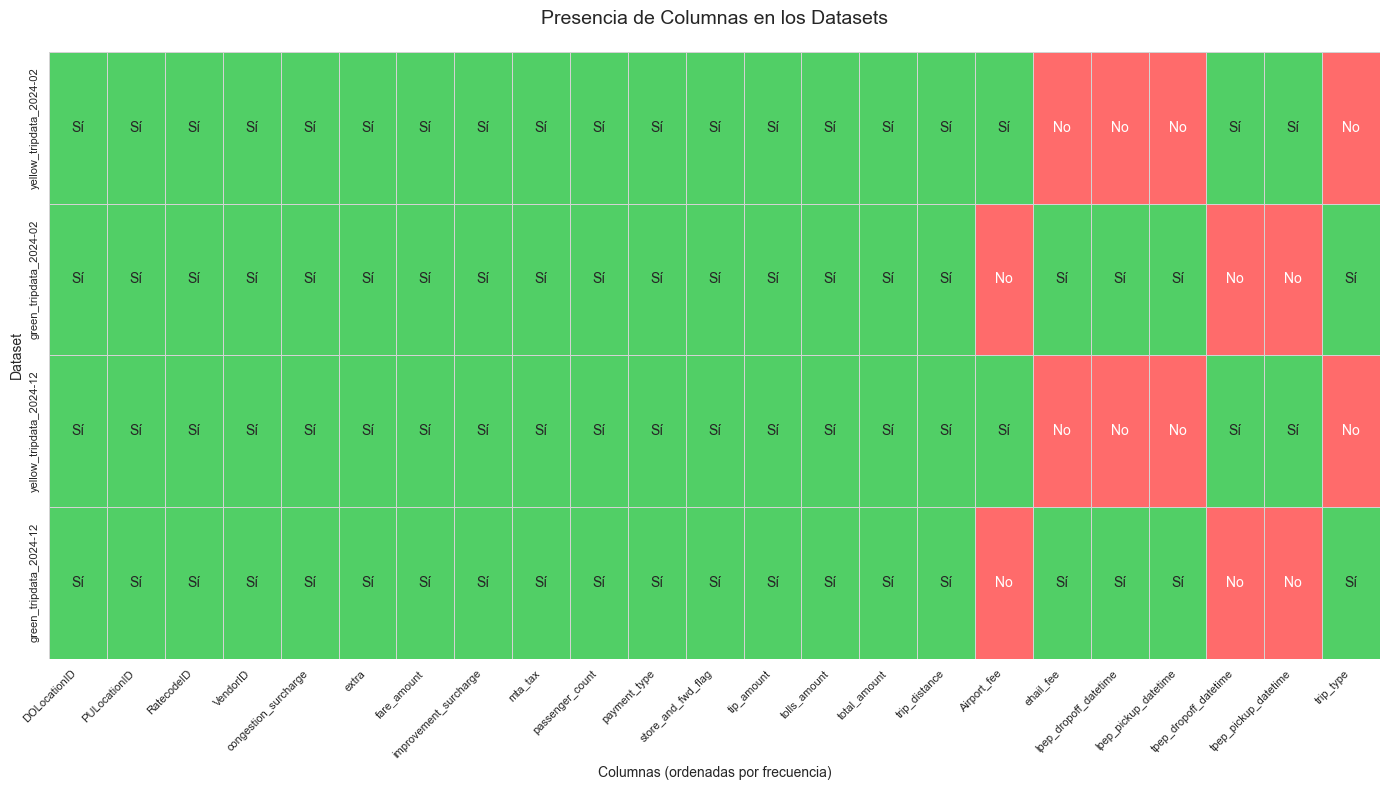

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_16720\3950756203.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_df.replace({"Sí": 1, "No": 0}),


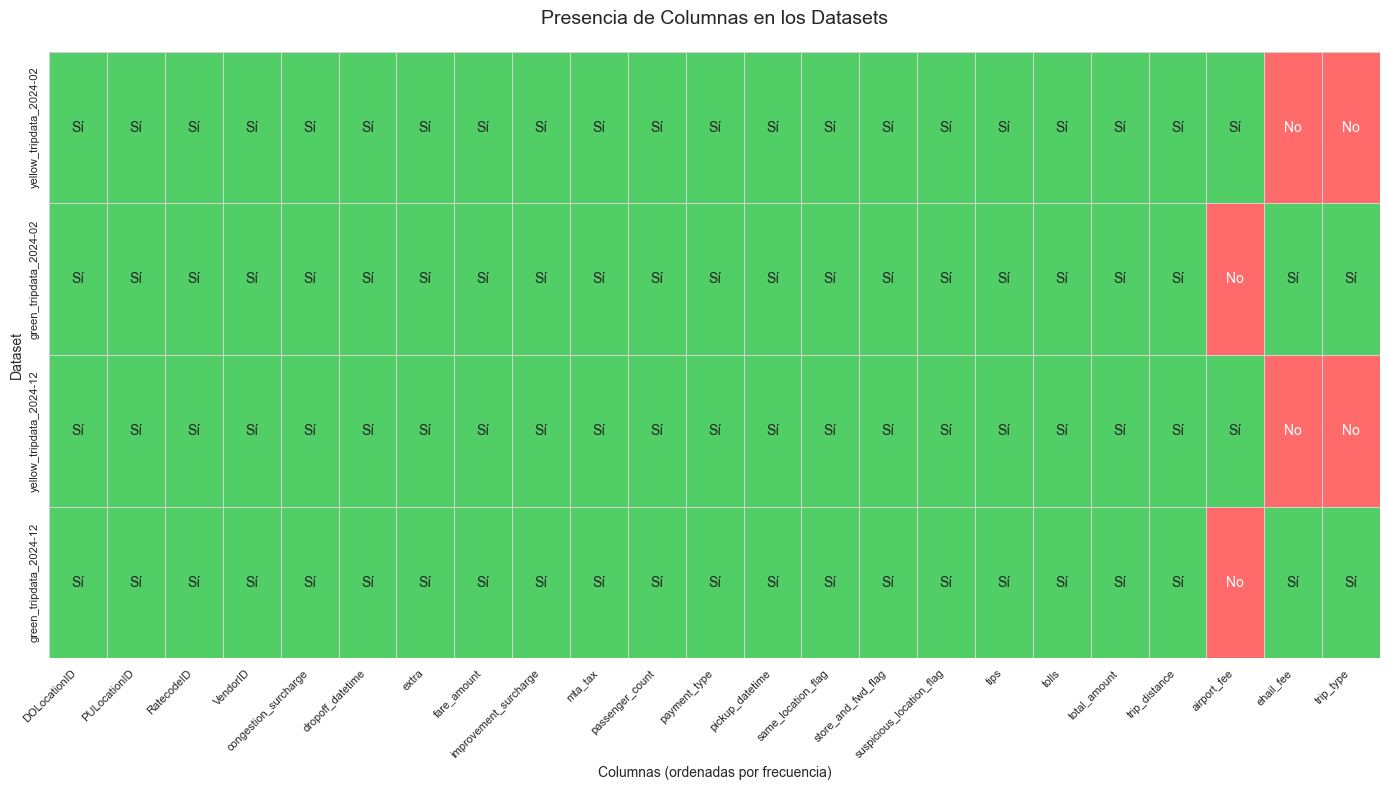

In [31]:
# heatmap de columnas antes de renombrar columnas
plot_column_presence_heatmap(original_datasets)
# heatmap de columnas después de renombrar columnas
plot_column_presence_heatmap(renamed_datasets)

### Guardado en parquet unificado 

In [32]:
# Guardar datasets renombrados
def guardar_parquets_unificados(datasets_dict, carpeta_salida="unified_parquets"):
    """
    Une los datasets yellow y green por mes (ignorando 2009) y guarda en formato Parquet.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        carpeta_salida: carpeta donde guardar los Parquet
    """
    os.makedirs(carpeta_salida, exist_ok=True)

    # Detección automática de los pares yellow/green
    meses = ["2024-02", "2024-12"]

    for mes in meses:
        yellow_key = f"yellow_tripdata_{mes}"
        green_key = f"green_tripdata_{mes}"

        if yellow_key in datasets_dict and green_key in datasets_dict:
            df_yellow = datasets_dict[yellow_key]
            df_green = datasets_dict[green_key]

            # Unión ignorando columnas que falten (en pandas)
            df_unificado = pd.concat([df_yellow, df_green], ignore_index=True, sort=False)

            # Ruta de salida
            ruta_salida = os.path.join(carpeta_salida, f"taxis_tripdata_{mes}.parquet")

            # Guardado
            df_unificado.to_parquet(ruta_salida, index=False)
            print(f"✅ Guardado: {ruta_salida}")
        else:
            print(f"⚠️  No se encontraron ambos datasets para {mes}, se omite.")

guardar_parquets_unificados(renamed_datasets)


✅ Guardado: unified_parquets\taxis_tripdata_2024-02.parquet
✅ Guardado: unified_parquets\taxis_tripdata_2024-12.parquet


### Unificación de datasets

In [33]:
taxis_df_2024_02 = pd.concat([
    renamed_datasets["yellow_tripdata_2024-02"],
    renamed_datasets["green_tripdata_2024-02"]
], ignore_index=True, sort=False)

taxis_df_2024_12 = pd.concat([
    renamed_datasets["yellow_tripdata_2024-12"],
    renamed_datasets["green_tripdata_2024-12"]
], ignore_index=True, sort=False)

## Limpieza de Datos

### Limpieza de datos con pandas

In [222]:
# Función para limpiar y normalizar datasets de taxis
# Esta función prepara los datos para asegurar su consistencia, detectar trayectos anómalos
# y optimizarlos para análisis posteriores, como modelos predictivos y análisis por precio/km.
def limpiar_dataset_integrado(datasets_dict, zona_nombres, min_freq=5):
    """
    Limpieza y validación exhaustiva de los datasets de trayectos NYC Taxi.

    Incorpora imputación, filtrado de outliers, validaciones de coherencia,
    y enriquecimiento de variables temporales y tarifarias.
    Se añaden filtros específicos para evitar registros con precio total o precio por km irrealmente bajos.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        zona_nombres: diccionario {zone_id: nombre_zona}
        min_freq: frecuencia mínima para imputación local

    Retorna:
        Diccionario con los DataFrames corregidos y enriquecidos.
    """
    datasets_corregidos = {}

    for nombre, df in datasets_dict.items():
        try:
            print(f"\n🔄 Procesando: {nombre}")
            df = df.copy()
            flags = []

            # --- 1. Validación inicial de columnas necesarias ---
            required_cols = {"pickup_datetime", "PULocationID", "DOLocationID", "total_amount", "trip_distance"}
            if not required_cols.issubset(df.columns):
                print(f"⚠️ {nombre}: faltan columnas mínimas requeridas. Se omite.")
                continue

            # --- 2. Conversión de fechas y tipos ---
            df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
            df["dropoff_datetime"] = pd.to_datetime(df.get("dropoff_datetime", pd.NaT), errors="coerce")

            # --- 3. Validación geográfica estricta ---
            mask_zonas_validas = (
                df["PULocationID"].notnull() &
                df["DOLocationID"].notnull() &
                df["PULocationID"].astype("Int64").isin(zona_nombres.keys()) &
                df["DOLocationID"].astype("Int64").isin(zona_nombres.keys())
            )
            flags.append(mask_zonas_validas)

            # --- 4. Imputación local de distancias ---
            df["key"] = list(zip(df["PULocationID"], df["DOLocationID"]))
            mask_td = df["trip_distance"].isnull() | (df["trip_distance"] <= 0)
            valid_td = df.loc[~mask_td].copy()
            freq = valid_td.groupby("key").size()
            comunes = freq[freq >= min_freq].index
            medianas_td = valid_td.groupby("key")["trip_distance"].median()

            def imputar_td(row):
                if row["key"] in comunes:
                    return medianas_td[row["key"]]
                return None

            df.loc[mask_td, "trip_distance"] = df.loc[mask_td].apply(imputar_td, axis=1)
            flags.append(~df["trip_distance"].isnull())

            # --- 5. Filtro: Distancia realista (entre 300m y 50mi) ---
            flags.append((df["trip_distance"] >= 0.3) & (df["trip_distance"] <= 50))

            # --- 6. Cálculo de duración de trayecto en minutos ---
            if "trip_duration_min" not in df.columns and "dropoff_datetime" in df.columns:
                df["trip_duration_min"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60

            # --- 7. Filtro: Duración realista (0 < t <= 180 min) ---
            mask_dur = df["trip_duration_min"].notnull() & (df["trip_duration_min"] > 0) & (df["trip_duration_min"] <= 180)
            flags.append(mask_dur)

            # --- 8. Filtro: Precio total positivo ---
            mask_amt = df["total_amount"].notnull() & (df["total_amount"] > 0)
            flags.append(mask_amt)

            # --- 9. Filtro: Precio por km realista (se refuerza para usar Precio ($)) ---
            # Ahora siempre usa la columna ajustada 'Precio ($)'.
            # Así evitamos trayectos largos a precios ridículos.
            # Este filtro se recalcula tras asignar la tarifa mínima más adelante.

            # --- 10. Filtro: Velocidad media realista (2 < v < 100 km/h) ---
            df["velocidad_media_kmh"] = (df["trip_distance"] * 1.60934) / (df["trip_duration_min"] / 60)
            flags.append((df["velocidad_media_kmh"] >= 2) & (df["velocidad_media_kmh"] <= 100))

            # --- 11. Filtro: Precio real/teórico coherente ---
            tarifa_inicial = 3.00
            tarifa_milla = 2.50
            tarifa_minuto = 0.70
            df["precio_teorico_estimado"] = (
                tarifa_inicial +
                df["trip_distance"] * tarifa_milla +
                df["trip_duration_min"] * tarifa_minuto
            )
            df["precio_ratio"] = df["total_amount"] / df["precio_teorico_estimado"]
            flags.append((df["precio_ratio"] < 3) & (df["precio_ratio"] > 0.3))

            # --- 12. Filtro: Trayectos con origen y destino distintos ---
            flags.append(df["PULocationID"] != df["DOLocationID"])

            # --- 13. Imputación local de pasajeros ---
            if "passenger_count" in df.columns:
                mask_pc = df["passenger_count"].isnull() | (df["passenger_count"] < 0)
                if mask_pc.any():
                    medianas_pc = df.loc[~mask_pc].groupby("key")["passenger_count"].median()
                    df.loc[mask_pc, "passenger_count"] = df.loc[mask_pc, "key"].map(medianas_pc)
                flags.append(~df["passenger_count"].isnull())

            # --- 14. Filtro crítico: minutos por kilómetro realistas ---
            df["min_per_km"] = df["trip_duration_min"] / (df["trip_distance"] * 1.60934)
            flags.append(df["min_per_km"] <= 20)

            # --- 15. Enriquecimiento temporal: hora, día y hora pico ---
            df["Hora"] = df["pickup_datetime"].dt.hour
            df["Dia"] = df["pickup_datetime"].dt.day_name()
            df['Hora_Pico'] = df['Hora'].apply(lambda x: 1 if (7 <= x < 10) or (16 <= x < 19) else 0)

            # --- 16. Tarifa mínima NYC: ---
            # Si la duración del viaje es menor a 2 minutos, se fuerza una tarifa mínima de $7.
            df["Precio ($)"] = df["total_amount"]
            df.loc[df["trip_duration_min"] < 2, "Precio ($)"] = 7.00

            # --- 17. Filtro adicional: precio total mínimo ---
            # Se eliminan trayectos con precio total irrealmente bajo (< 2$), salvo si ya se ha ajustado por tarifa mínima.
            df = df[df["Precio ($)"] >= 2.00]

            # --- 18. Filtro de outliers por precio/minuto ---
            df["$/min"] = df["Precio ($)"] / df["trip_duration_min"]
            df = df[df["$/min"] <= 5]

            # --- 19. Filtro reforzado: Precio por km realista ---
            # Ahora se calcula SIEMPRE sobre 'Precio ($)' ya ajustado
            df["fare_per_km"] = df["Precio ($)"] / (df["trip_distance"] * 1.60934)
            # Se filtran precios por km demasiado bajos o altos
            df = df[(df["fare_per_km"] >= 0.2) & (df["fare_per_km"] <= 100)]

            # --- Aplicación final de los flags (para el resto de filtros lógicos previos) ---
            df["flag_limpieza"] = flags[0]
            for f in flags[1:]:
                df["flag_limpieza"] &= f

            df_final = df[df["flag_limpieza"]].copy()
            df_final.drop(
                columns=["key", "flag_limpieza", "velocidad_media_kmh", "min_per_km", "$/min"],
                inplace=True,
                errors="ignore"
            )

            datasets_corregidos[nombre] = df_final
            print(f"✅ {nombre}: limpieza completada con {len(df_final)} registros válidos.")

        except Exception as e:
            print(f"❌ Error procesando {nombre}: {e}")
            continue

    return datasets_corregidos


# Aplicar limpieza a los datasets renombrados
unified_datasets = {
    "taxis_tripdata_2024-02": taxis_df_2024_02,
    "taxis_tripdata_2024-12": taxis_df_2024_12
}
# Aplicar limpieza a los datasets renombrados
cleaned_datasets = limpiar_dataset_integrado(unified_datasets, zona_nombres)


🔄 Procesando: taxis_tripdata_2024-02


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_16720\2166363443.py:141: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.



✅ taxis_tripdata_2024-02: limpieza completada con 2824622 registros válidos.

🔄 Procesando: taxis_tripdata_2024-12


C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_16720\2166363443.py:141: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.



✅ taxis_tripdata_2024-12: limpieza completada con 3351114 registros válidos.


### Guardar los datasets limpios en parquet

In [204]:
# Guardar datasets renombrados
def guardar_datasets_limpios(datasets_dict, carpeta_salida="cleaned_parquets", guardar_csv=False):
    """
    Guarda cada DataFrame del diccionario en formato Parquet dentro de la carpeta especificada.
    
    Opcionalmente, también guarda cada DataFrame como CSV.

    Parámetros:
        datasets_dict: dict[str, pd.DataFrame] - Diccionario {nombre_dataset: DataFrame}
        carpeta_salida: str - Carpeta donde guardar los archivos .parquet
        guardar_csv: bool - Si True, también guarda cada archivo como .csv
    """
    os.makedirs(carpeta_salida, exist_ok=True)

    for nombre, df in datasets_dict.items():
        if not isinstance(df, pd.DataFrame):
            print(f"❌ El valor asociado a '{nombre}' no es un DataFrame. Se omite.")
            continue

        try:
            nombre_archivo = f"{nombre}.parquet"
            ruta_parquet = os.path.join(carpeta_salida, nombre_archivo)
            df.to_parquet(ruta_parquet, index=False)
            print(f"✅ Guardado Parquet: {ruta_parquet}")

            if guardar_csv:
                nombre_csv = f"{nombre}.csv"
                ruta_csv = os.path.join(carpeta_salida, nombre_csv)
                df.to_csv(ruta_csv, index=False)
                print(f"📄 Guardado CSV: {ruta_csv}")

        except Exception as e:
            print(f"❌ Error al guardar '{nombre}': {e}")

guardar_datasets_limpios(cleaned_datasets)


✅ Guardado Parquet: cleaned_parquets\taxis_tripdata_2024-02.parquet
✅ Guardado Parquet: cleaned_parquets\taxis_tripdata_2024-12.parquet


### (Opcional) - Cargar todos los datasets *.parquet limpios en un diccionario 
Es opcional si ya los tenemos creados, podríamos cargarlos directamente en vez de pasar todo el proceso de renombrado, limpieza, unificación y guardado.

In [ ]:
def cargar_datasets_parquet(carpeta="cleaned_parquets"):
    """
    Carga los archivos .parquet uno a uno desde la carpeta especificada
    y los guarda en un diccionario con nombres legibles.

    Evita problemas de memoria al no cargar todos simultáneamente.
    """
    datasets = {}
    for archivo in os.listdir(carpeta):
        if archivo.endswith(".parquet"):
            nombre_dataset = archivo.replace(".parquet", "")
            ruta = os.path.join(carpeta, archivo)
            try:
                print(f"📥 Cargando: {nombre_dataset}")
                df = pd.read_parquet(ruta)
                datasets[nombre_dataset] = df
            except Exception as e:
                print(f"⚠️ Error al cargar {nombre_dataset}: {e}")
    return datasets

# Cargar los datasets renombrados desde parquet
""" renamed_datasets = cargar_datasets_parquet("datasets_limpios") """
# Verificar la carga
""" for name, df in renamed_datasets.items():
    print(f"{name}: {df.shape[0]:,} filas, {df.shape[1]} columnas") """

### ¿Existen valores aparentemente incorrectos?
Analiza todos los DataFrames en un diccionario (como cleaned_datasets). La función evalúa los mismos valores inválidos y genera un resumen por dataset.

In [223]:
# Verificación de calidad de columnas
def analizar_valores_invalidos_dict(datasets_dict):
    """
    Analiza valores inválidos en un diccionario de datasets (DataFrames).

    Evalúa:
    - Valores nulos o incoherentes en pasajeros, distancia, importe, duración y zonas.
    - Zonas fuera del listado válido (`zona_nombres`), en lugar de asumir un rango arbitrario.

    Devuelve:
        Un DataFrame resumen con el conteo de errores por tipo y dataset.
    """
    resumen = []

    for nombre, df in datasets_dict.items():
        resultados = {}
        print(f"🔍 Analizando: {nombre}")

        # Detectar columnas relevantes
        def get_first_existing(group):
            return next((col for col in group if col in df.columns), None)

        col_passengers = 'passenger_count' if 'passenger_count' in df.columns else None
        col_distance = 'trip_distance' if 'trip_distance' in df.columns else None
        col_total = 'total_amount' if 'total_amount' in df.columns else None
        col_pu = get_first_existing(column_groups['PULocationID'])
        col_do = get_first_existing(column_groups['DOLocationID'])
        col_pickup = get_first_existing(column_groups['pickup_datetime'])
        col_dropoff = get_first_existing(column_groups['dropoff_datetime'])

        # 1. Pasajeros
        if col_passengers:
            resultados['Pasajeros = nulos'] = df[col_passengers].isna().sum()
            resultados['Pasajeros < 0'] = (df[col_passengers] < 0).sum()

        # 2. Distancia
        if col_distance:
            resultados['Distancia = nula'] = df[col_distance].isna().sum()
            resultados['Distancia <= 0'] = (df[col_distance] <= 0).sum()

        # 3 y 4. Duración inválida
        if col_pickup and col_dropoff:
            pickup = pd.to_datetime(df[col_pickup], errors='coerce')
            dropoff = pd.to_datetime(df[col_dropoff], errors='coerce')
            resultados['Pickup/dropoff = nulos'] = pickup.isna().sum() + dropoff.isna().sum()
            resultados['Dropoff < Pickup'] = (dropoff < pickup).sum()
            resultados['Duración = 0 min'] = (dropoff == pickup).sum()

        # 5. Total
        if col_total:
            resultados['Total_amount = nulo'] = df[col_total].isna().sum()
            resultados['Total_amount <= 0'] = (df[col_total] <= 0).sum()

        # 6. Ubicaciones - usando zona_nombres en lugar de rango fijo
        if col_pu:
            resultados['PULocationID = nulo'] = df[col_pu].isna().sum()
            resultados['PULocationID fuera de rango'] = df[~df[col_pu].isin(zona_nombres.keys())].shape[0]
        if col_do:
            resultados['DOLocationID = nulo'] = df[col_do].isna().sum()
            resultados['DOLocationID fuera de rango'] = df[~df[col_do].isin(zona_nombres.keys())].shape[0]

        # Agregar los resultados al resumen
        for k, v in resultados.items():
            resumen.append({"Dataset": nombre, "Tipo de error": k, "Nº de registros": v})

    return pd.DataFrame(resumen)

# Verificación de calidad de columnas
df_errores = analizar_valores_invalidos_dict(cleaned_datasets)
display(df_errores)

# Verificación de calidad de columnas
""" df_original_errores = analizar_valores_invalidos_dict(datasets)
display(df_original_errores) """

🔍 Analizando: taxis_tripdata_2024-02
🔍 Analizando: taxis_tripdata_2024-12


,Dataset,Tipo de error,Nº de registros
0,taxis_tripdata_2024-02,Pasajeros = nulos,0
1,taxis_tripdata_2024-02,Pasajeros < 0,0
2,taxis_tripdata_2024-02,Distancia = nula,0
3,taxis_tripdata_2024-02,Distancia <= 0,0
4,taxis_tripdata_2024-02,Pickup/dropoff = nulos,0
5,taxis_tripdata_2024-02,Dropoff < Pickup,0
6,taxis_tripdata_2024-02,Duración = 0 min,0
7,taxis_tripdata_2024-02,Total_amount = nulo,0
8,taxis_tripdata_2024-02,Total_amount <= 0,0
9,taxis_tripdata_2024-02,PULocationID = nulo,0


' df_original_errores = analizar_valores_invalidos_dict(datasets)\ndisplay(df_original_errores) '

#### Gráfico combinado para representar de forma clara y visual los outliers en las variables más propensas a errores

In [ ]:
def comparar_outliers_multivariables(unified_datasets, limpio_dict):
    """
    Compara histogramas de distancia, duración y total_amount para datasets originales y limpios.
    Omite datasets sin las columnas requeridas.
    """
    for nombre in unified_datasets:
        if nombre not in limpio_dict:
            print(f"⚠️ {nombre} no está en el conjunto limpio. Se omite.")
            continue

        df_orig = unified_datasets[nombre].copy()
        df_limpio = limpio_dict[nombre].copy()

        # Verificar columnas necesarias
        if "trip_distance" not in df_orig.columns or "trip_distance" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'trip_distance'. Se omite.")
            continue

        if "trip_duration_min" not in df_orig.columns:
            pickup_cols = [c for c in ['tpep_pickup_datetime', 'lpep_pickup_datetime', 'pickup_datetime'] if c in df_orig.columns]
            dropoff_cols = [c for c in ['tpep_dropoff_datetime', 'lpep_dropoff_datetime', 'dropoff_datetime', 'dropOff_datetime'] if c in df_orig.columns]
            if pickup_cols and dropoff_cols:
                df_orig["trip_duration_min"] = (
                    pd.to_datetime(df_orig[dropoff_cols[0]], errors="coerce") -
                    pd.to_datetime(df_orig[pickup_cols[0]], errors="coerce")
                ).dt.total_seconds() / 60

        if "trip_duration_min" not in df_limpio.columns and "trip_duration_min" in df_orig.columns:
            df_limpio["trip_duration_min"] = df_orig["trip_duration_min"]

        if "trip_duration_min" not in df_orig.columns or "trip_duration_min" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'trip_duration_min'. Se omite.")
            continue

        if "total_amount" not in df_orig.columns or "total_amount" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'total_amount'. Se omite.")
            continue

        # Filtrado para visualización
        df_orig = df_orig[
            (df_orig["trip_distance"] < 20) &
            (df_orig["trip_duration_min"] < 60) &
            (df_orig["total_amount"] < 100)
        ]
        df_limpio = df_limpio[
            (df_limpio["trip_distance"] < 20) &
            (df_limpio["trip_duration_min"] < 60) &
            (df_limpio["total_amount"] < 100)
        ]

        # Visualización
        fig, axs = plt.subplots(3, 1, figsize=(12, 10))
        fig.suptitle(f"Distribución de trayectos – {nombre}", fontsize=16)

        # Distancia
        sns.histplot(df_orig["trip_distance"], bins=60, color="lightcoral", label="Original", ax=axs[0], alpha=0.6)
        sns.histplot(df_limpio["trip_distance"], bins=60, color="seagreen", label="Limpio", ax=axs[0], alpha=0.6)
        axs[0].set_title("Histograma de distancias (<20 mi)")
        axs[0].legend()

        # Duración
        sns.histplot(df_orig["trip_duration_min"], bins=60, color="lightcoral", label="Original", ax=axs[1], alpha=0.6)
        sns.histplot(df_limpio["trip_duration_min"], bins=60, color="seagreen", label="Limpio", ax=axs[1], alpha=0.6)
        axs[1].set_title("Histograma de duración (<60 min)")
        axs[1].legend()

        # Total amount
        sns.histplot(df_orig["total_amount"], bins=60, color="lightcoral", label="Original", ax=axs[2], alpha=0.6)
        sns.histplot(df_limpio["total_amount"], bins=60, color="seagreen", label="Limpio", ax=axs[2], alpha=0.6)
        axs[2].set_title("Histograma de importe total (<100 $)")
        axs[2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
# Muestra de comparación de outliers
comparar_outliers_multivariables(unified_datasets, cleaned_datasets)

## 1.2 Empezamos por visualizar el dataset. Haced un plot en el que, para cada dataset, se muestren el número de trayectos entre zonas de forma que en el eje horizontal estén las zonas de recogida y en el eje vertical las zonas de llegada. Extrae conclusiones preliminares. ¿Se aprecian diferencias entre los puntos de los Yellow Cabs y los de los Green Cabs? ¿Se aprecian diferencias entre un mes y otro?

### Visualización de trayectos entre las 20 zonas más activas
- Recorre ambos diccionarios de datasets (originales y limpios).
- Genera un heatmap para cada uno.
- Quita los números dentro de las celdas (annot=False) para que se infieran por escala de color.
- Usa plotly.express.imshow para interactividad: permite ver el valor al pasar el ratón.

In [ ]:
def comparar_heatmaps_zonas_activas(unified_datasets, limpio_dict, top_n=20):
    """
    Compara visualmente los heatmaps de trayectos entre zonas más activas
    entre datasets originales y limpios usando interactividad.

    Parámetros:
    - unified_datasets: diccionario con datasets originales
    - limpio_dict: diccionario con datasets limpios
    - top_n: número de zonas más activas a considerar
    """
    for nombre in unified_datasets:
        if nombre not in limpio_dict:
            continue

        df_orig = unified_datasets[nombre]
        df_limpio = limpio_dict[nombre]

        for df, version in zip([df_orig, df_limpio], ["Original", "Limpio"]):
            # Validar columnas necesarias
            if not {'PULocationID', 'DOLocationID'}.issubset(df.columns):
                print(f"⚠️ {nombre} ({version}): columnas de ubicación no encontradas. Se omite.")
                continue

            # Agrupar trayectos
            zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

            # Top zonas más frecuentes
            top_pu = zonas.groupby('PULocationID')['count'].sum().nlargest(top_n).index
            top_do = zonas.groupby('DOLocationID')['count'].sum().nlargest(top_n).index

            # Filtrar top zonas
            zonas_top = zonas[
                zonas['PULocationID'].isin(top_pu) & zonas['DOLocationID'].isin(top_do)
            ]

            # Pivotear para heatmap
            pivot = zonas_top.pivot(index='DOLocationID', columns='PULocationID', values='count').fillna(0)

            # Plot interactivo con plotly
            fig = px.imshow(
                pivot.values,
                labels=dict(x="PULocationID", y="DOLocationID", color="Nº de Trayectos"),
                x=pivot.columns,
                y=pivot.index,
                color_continuous_scale="YlGnBu",
                title=f"Trayectos entre zonas más activas – {nombre} ({version})"
            )
            fig.update_layout(height=600, width=700)
            fig.show()

comparar_heatmaps_zonas_activas(unified_datasets, cleaned_datasets)

In [ ]:
# Función para generar un diagrama de Sankey con las 5 zonas más populares
def plot_sankey_top5_dict(datasets_dict, zona_nombres):
    """
    Genera un diagrama de Sankey para cada dataset en el diccionario,
    mostrando los trayectos entre las 5 zonas más frecuentes (origen/destino).

    Parámetros:
    - datasets_dict: diccionario {nombre_dataset: DataFrame}
    - zona_nombres: diccionario {LocationID: Nombre de zona}

    Devuelve:
    - lista de figuras Sankey (una por dataset)
    """
    import plotly.graph_objects as go

    figuras = []

    for nombre, df in datasets_dict.items():
        if "PULocationID" not in df.columns or "DOLocationID" not in df.columns:
            print(f"⚠️ {nombre}: no contiene columnas de ubicación. Se omite.")
            continue

        zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

        # Top 5 zonas más activas combinando origen y destino
        zonas_frecuentes = pd.concat([
            zonas.groupby('PULocationID')['count'].sum(),
            zonas.groupby('DOLocationID')['count'].sum()
        ]).groupby(level=0).sum().nlargest(5).index.tolist()

        zonas_top5 = zonas[
            zonas['PULocationID'].isin(zonas_frecuentes) &
            zonas['DOLocationID'].isin(zonas_frecuentes)
        ]

        if zonas_top5.empty:
            print(f"⚠️ {nombre}: no hay suficientes trayectos entre las 5 zonas más frecuentes.")
            continue

        etiquetas = [f"{z} - {zona_nombres.get(z, 'Desconocido')}" for z in zonas_frecuentes]
        zona_idx = {zona: i for i, zona in enumerate(zonas_frecuentes)}

        source = zonas_top5['PULocationID'].map(zona_idx).tolist()
        target = zonas_top5['DOLocationID'].map(zona_idx).tolist()
        value = zonas_top5['count'].tolist()

        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15, thickness=20,
                line=dict(color="black", width=0.5),
                label=etiquetas
            ),
            link=dict(source=source, target=target, value=value)
        )])

        fig.update_layout(
            title_text=f"Trayectos entre las 5 zonas más populares – {nombre}",
            font_size=12
        )

        fig.show()
        #figuras.append(fig)

    return figuras

# Generamos diagramas de Sankey para los datasets de Febrero 2024 y Diciembre 2024 limpios
# Asumiendo que zona_nombres ya está cargado
plot_sankey_top5_dict(cleaned_datasets, zona_nombres)

## 1.4	Mejora la visualización anterior con un heat map. Ayúdate de los Zone Map…

In [ ]:
def plot_heatmap_top5_dict(datasets_dict):
    """
    Genera un heatmap con trayectos entre las 5 zonas más populares para cada dataset del diccionario.

    Se espera que las claves del diccionario sigan el formato: tipo_tripdata_aaaa-mm

    Parámetros:
    - datasets_dict: diccionario {nombre_dataset: DataFrame}
    """
    for key, df in datasets_dict.items():
        # Parsear tipo de taxi y fecha desde el nombre del archivo
        try:
            tipo, _, fecha = key.split("_")
            año, mes = fecha.split("-")
            mes_label = f"{mes}/{año}"
            nombre_dataset = tipo.capitalize() + " Cabs"
        except Exception as e:
            print(f"❌ No se pudo interpretar '{key}': {e}")
            continue

        # Verificar columnas necesarias
        if not all(col in df.columns for col in ["PULocationID", "DOLocationID"]):
            print(f"⚠️ {key}: columnas de ubicación no encontradas. Se omite.")
            continue

        # Agrupar trayectos
        zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

        # Zonas más activas (top 5 combinando origen y destino)
        zonas_frecuentes = pd.concat([
            zonas.groupby('PULocationID')['count'].sum(),
            zonas.groupby('DOLocationID')['count'].sum()
        ]).groupby(level=0).sum().nlargest(5).index.tolist()

        # Filtrar trayectos entre esas zonas
        zonas_top5 = zonas[
            zonas['PULocationID'].isin(zonas_frecuentes) &
            zonas['DOLocationID'].isin(zonas_frecuentes)
        ].copy()

        # Mapeo a nombres de zonas
        zonas_top5["Zona origen"] = zonas_top5["PULocationID"].map(zona_nombres)
        zonas_top5["Zona destino"] = zonas_top5["DOLocationID"].map(zona_nombres)

        # Crear clave de combinación
        zonas_top5["Zona"] = zonas_top5["Zona origen"] + " → " + zonas_top5["Zona destino"]
        zonas_top5["Mes-Tipo"] = f"{mes_label} ({nombre_dataset})"

        # Pivot para heatmap
        pivot_df = zonas_top5.pivot(index="Zona", columns="Mes-Tipo", values="count").fillna(0)

        # Dibujar heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Número de trayectos'})
        plt.title(f"Heatmap – Top 5 zonas más populares ({mes_label}, {nombre_dataset})")
        plt.ylabel("Zona origen → destino")
        plt.xlabel("Mes y tipo de taxi")
        plt.tight_layout()
        plt.show()

# Generamos heatmaps para los datasets Limpios
plot_heatmap_top5_dict(cleaned_datasets)

# Segunda Parte: Análisis Cualitativo

## 2.1	¿Cuál es el trayecto en el que la relación precio/km es más alta? ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? ¿Cuál es el trayecto en el que la relación precio/tiempo es más alta?

## Identificador de Outliers

In [189]:
# Función para detectar outliers multivariables en datasets de taxis
def identificar_outliers_dict(datasets_dict):
    """
    Detecta outliers en múltiples variables clave de trayectos de taxi mediante el método IQR (Interquartile Range).

    Variables evaluadas:
    - trip_distance (distancia del viaje)
    - fare_amount (importe del trayecto)
    - trip_duration_min (duración estimada en minutos)
    - fare_per_km (importe por kilómetro recorrido)

    Se calcula un resumen para cada dataset y se muestra por pantalla:
    - Número de outliers por variable
    - Límites inferior y superior según IQR

    Retorna:
        dict con {nombre_dataset: DataFrame con filas outlier y columna adicional 'Outlier en'}
    """
    outliers_dict = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()
        print(f"\n📊 Analizando dataset: {nombre}")

        # Asegurar columna de duración si no existe
        if "trip_duration_min" not in df.columns:
            pickup_cols = [c for c in ['tpep_pickup_datetime', 'lpep_pickup_datetime', 'pickup_datetime'] if c in df.columns]
            dropoff_cols = [c for c in ['tpep_dropoff_datetime', 'lpep_dropoff_datetime', 'dropoff_datetime', 'dropOff_datetime'] if c in df.columns]
            if pickup_cols and dropoff_cols:
                df["trip_duration_min"] = (
                    pd.to_datetime(df[dropoff_cols[0]], errors="coerce") -
                    pd.to_datetime(df[pickup_cols[0]], errors="coerce")
                ).dt.total_seconds() / 60

        # Calcular fare_per_km si no existe
        if 'fare_amount' in df.columns and 'trip_distance' in df.columns:
            df = df[df['trip_distance'] > 0].copy()
            df['fare_per_km'] = df['fare_amount'] / (df['trip_distance'] * 1.60934)  # ajuste a km

        # Selección de columnas relevantes
        columnas = ['trip_distance', 'fare_amount', 'trip_duration_min', 'fare_per_km']
        columnas = [col for col in columnas if col in df.columns]

        outlier_flags = pd.DataFrame(index=df.index)
        resumen = []

        # Aplicar método IQR a cada columna
        for col in columnas:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lim_inf = Q1 - 1.5 * IQR
            lim_sup = Q3 + 1.5 * IQR

            flag = (df[col] < lim_inf) | (df[col] > lim_sup)
            outlier_flags[col + '_outlier'] = flag
            resumen.append((col, flag.sum(), lim_inf, lim_sup))

        # Combinar todos los outliers
        outlier_rows = df[outlier_flags.any(axis=1)].copy()
        if not outlier_rows.empty:
            outlier_rows['Outlier en'] = outlier_flags[outlier_flags.any(axis=1)].apply(
                lambda x: ', '.join(x.index[x].str.replace('_outlier', '')), axis=1
            )
            outliers_dict[nombre] = outlier_rows

        # Mostrar resumen por pantalla con detalles
        print("  📌 Resumen de outliers detectados:")
        for col, count, low, high in resumen:
            print(f"    ▪ {col:<18}: {count:>5} outliers fuera de rango [{low:.2f}, {high:.2f}]")

        if not resumen:
            print("    ⚠️ No se encontraron columnas numéricas válidas para análisis.")

    print("\n✅ Análisis de outliers finalizado.")
    return outliers_dict

# Ejecutar la detección sobre los datasets limpios
detectados = identificar_outliers_dict(cleaned_datasets)


📊 Analizando dataset: taxis_tripdata_2024-02
  📌 Resumen de outliers detectados:
    ▪ trip_distance     : 356088 outliers fuera de rango [-2.17, 6.55]
    ▪ fare_amount       : 281654 outliers fuera de rango [-7.59, 37.45]
    ▪ trip_duration_min : 162284 outliers fuera de rango [-9.53, 37.13]
    ▪ fare_per_km       : 98574 outliers fuera de rango [0.64, 8.43]

📊 Analizando dataset: taxis_tripdata_2024-12
  📌 Resumen de outliers detectados:
    ▪ trip_distance     : 439586 outliers fuera de rango [-2.43, 6.98]
    ▪ fare_amount       : 282040 outliers fuera de rango [-11.78, 46.30]
    ▪ trip_duration_min : 192794 outliers fuera de rango [-13.51, 45.89]
    ▪ fare_per_km       : 181331 outliers fuera de rango [-0.06, 9.87]

✅ Análisis de outliers finalizado.


###  Muestra un resumen por DataSet de registros con incoherencias entre distancia y precio. 

In [224]:
def analizar_incoherencias_distancia_precio(datasets_dict, z_thresh=3.0, min_registros=100):
    """
    Analiza incoherencias entre trip_distance y fare_amount usando regresión lineal.
    No modifica los datasets. Solo informa.

    Parámetros:
    - datasets_dict: diccionario {nombre: DataFrame}
    - z_thresh: umbral de Z-score para considerar un registro incoherente
    - min_registros: mínimo de registros para aplicar regresión

    Muestra un resumen con el número de incoherencias detectadas por dataset.
    """
    resumen = []

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Validar columnas necesarias
        if "trip_distance" not in df.columns or "fare_amount" not in df.columns:
            print(f"❌ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        # Filtrar registros válidos
        df_validos = df[
            df["trip_distance"].notnull() &
            df["fare_amount"].notnull() &
            (df["trip_distance"] > 0) &
            (df["fare_amount"] > 0)
        ]

        if len(df_validos) < min_registros:
            print(f"⚠️ {nombre}: solo {len(df_validos)} registros válidos. Se omite.")
            continue

        # Regresión lineal
        X = df_validos[["trip_distance"]].values
        y = df_validos["fare_amount"].values
        modelo = LinearRegression()
        modelo.fit(X, y)

        # Calcular residuos y z-score
        y_pred = modelo.predict(X)
        residuos = y - y_pred
        z_residuos = zscore(residuos)

        # Identificar incoherencias
        incoherentes = (abs(z_residuos) > z_thresh).sum()
        total = len(df_validos)
        porcentaje = 100 * incoherentes / total

        resumen.append({
            "Dataset": nombre,
            "Registros válidos": total,
            "Incoherencias (> z_thresh)": incoherentes,
            "% Incoherente": f"{porcentaje:.2f}%"
        })

    # Mostrar resumen
    print("\n📊 Resumen de incoherencias entre distancia y precio (regresión):")
    display(pd.DataFrame(resumen))

# Ejemplo de uso
analizar_incoherencias_distancia_precio(cleaned_datasets, 3)



📊 Resumen de incoherencias entre distancia y precio (regresión):


,Dataset,Registros válidos,Incoherencias (> z_thresh),% Incoherente
0,taxis_tripdata_2024-02,2824394,43429,1.54%
1,taxis_tripdata_2024-12,3350354,55912,1.67%


### Trayecto con mayor precio por km

In [225]:
# Función para encontrar el trayecto con mayor precio por kilómetro
# incluyendo posibles causas del alto precio (recargos, hora punta, etc.)
def trayecto_mayor_precio_por_km(datasets_dict, zona_nombres):
    """
    Encuentra el trayecto con la mayor relación precio/km para cada dataset
    y también a nivel global, mostrando información extendida:

    - Zona origen y destino (ID + nombre)
    - Duración del trayecto
    - Precio/km
    - Hora punta (Sí/No)
    - Día de la semana
    - Presencia de tasas (peajes, nocturnidad, aeropuerto...)
    - Comparación entre precio registrado y precio teórico según tarifas oficiales

    El objetivo es entender si un trayecto con precio elevado por kilómetro se debe a:
    ▪ Alta duración con poca distancia (tráfico severo o espera larga)
    ▪ Recargos según horario (noche, hora punta)
    ▪ Peajes o recargos fijos por aeropuerto

    Retorna:
        DataFrame con resumen por dataset y global.
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        required = ["trip_distance", "fare_amount", "PULocationID", "DOLocationID", "trip_duration_min", "pickup_datetime"]
        if not all(col in df.columns for col in required):
            print(f"⚠️ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        # Si no existe la columna 'Hora_Pico', la calculamos aquí para asegurar consistencia.
        if "Hora_Pico" not in df.columns:
            df["Hora"] = pd.to_datetime(df["pickup_datetime"], errors="coerce").dt.hour
            df['Hora_Pico'] = df['Hora'].apply(lambda x: 1 if (7 <= x < 10) or (16 <= x < 19) else 0)

        # También aseguramos que tenemos el día de la semana
        if "Dia" not in df.columns:
            df["Dia"] = pd.to_datetime(df["pickup_datetime"], errors="coerce").dt.day_name()

        df = df[
            (df["trip_distance"] > 0) &
            (df["fare_amount"] > 0) &
            (df["trip_duration_min"] > 0) &
            (df["PULocationID"].notnull()) &
            (df["DOLocationID"].notnull())
        ].copy()

        if df.empty:
            print(f"⚠️ {nombre}: sin registros válidos para calcular precio/km.")
            continue

        # Precio teórico según tarifas oficiales
        tarifa_inicial = 3.00
        tarifa_milla = 2.50
        tarifa_minuto = 0.70

        df["precio_teorico_estimado"] = (
            tarifa_inicial +
            df["trip_distance"] * tarifa_milla +
            df["trip_duration_min"] * tarifa_minuto
        )

        df["precio_ratio"] = df["fare_amount"] / df["precio_teorico_estimado"]

        if df.empty:
            print(f"⚠️ {nombre}: sin registros tras filtrar trayectos con velocidad irreal.")
            continue

        df["fare_per_km"] = df["fare_amount"] / (df["trip_distance"] * 1.60934)
        top = df.loc[df["fare_per_km"].idxmax()]

        # Hora punta como Sí/No
        hora_pico_str = "Sí" if int(top.get("Hora_Pico", 0)) == 1 else "No"
        weekday = top.get("Dia") if pd.notnull(top.get("Dia")) else None

        recargos = []
        if "mta_tax" in top and top["mta_tax"] > 0:
            recargos.append("MTA")
        if "tolls_amount" in top and top["tolls_amount"] > 0:
            recargos.append("Peaje")
        if "congestion_surcharge" in top and top["congestion_surcharge"] > 0:
            recargos.append("Congestión")
        if "airport_fee" in top and top["airport_fee"] > 0:
            recargos.append("Aeropuerto")
        if "night_surcharge" in top and top["night_surcharge"] > 0:
            recargos.append("Noche")
        if "extra" in top and top["extra"] > 0:
            recargos.append("Extra")

        origen = int(top["PULocationID"])
        destino = int(top["DOLocationID"])
        origen_str = f"{origen} - {zona_nombres.get(origen, 'Desconocido')}"
        destino_str = f"{destino} - {zona_nombres.get(destino, 'Desconocido')}"

        resumen.append({
            "Dataset": nombre,
            "Origen": origen_str,
            "Destino": destino_str,
            "Distancia (mi)": top["trip_distance"],
            "Precio ($)": top["fare_amount"],
            "Precio/km ($)": top["fare_per_km"],
            "Duración (min)": top["trip_duration_min"],
            "Hora Punta": hora_pico_str,
            "Día": weekday,
            "Recargos": ", ".join(recargos) if recargos else "Ninguno",
            "Precio Teórico ($)": top["precio_teorico_estimado"],
            "Ratio Real/Teórico": top["precio_ratio"]
        })

        if global_max is None or top["fare_per_km"] > global_max["fare_per_km"]:
            global_max = top
            global_name = nombre

    if global_max is not None:
        hora_pico_str = "Sí" if int(global_max.get("Hora_Pico", 0)) == 1 else "No"
        weekday = global_max.get("Dia") if pd.notnull(global_max.get("Dia")) else None

        recargos = []
        if "mta_tax" in global_max and global_max["mta_tax"] > 0:
            recargos.append("MTA")
        if "tolls_amount" in global_max and global_max["tolls_amount"] > 0:
            recargos.append("Peaje")
        if "congestion_surcharge" in global_max and global_max["congestion_surcharge"] > 0:
            recargos.append("Congestión")
        if "airport_fee" in global_max and global_max["airport_fee"] > 0:
            recargos.append("Aeropuerto")
        if "night_surcharge" in global_max and global_max["night_surcharge"] > 0:
            recargos.append("Noche")
        if "extra" in global_max and global_max["extra"] > 0:
            recargos.append("Extra")

        origen = int(global_max["PULocationID"])
        destino = int(global_max["DOLocationID"])
        origen_str = f"{origen} - {zona_nombres.get(origen, 'Desconocido')}"
        destino_str = f"{destino} - {zona_nombres.get(destino, 'Desconocido')}"

        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": origen_str,
            "Destino": destino_str,
            "Distancia (mi)": global_max["trip_distance"],
            "Precio ($)": global_max["fare_amount"],
            "Precio/km ($)": global_max["fare_per_km"],
            "Duración (min)": global_max["trip_duration_min"],
            "Hora Punta": hora_pico_str,
            "Día": weekday,
            "Recargos": ", ".join(recargos) if recargos else "Ninguno",
            "Precio Teórico ($)": global_max["precio_teorico_estimado"],
            "Ratio Real/Teórico": global_max["precio_ratio"]
        })

    return pd.DataFrame(resumen)


# Ejecutar
print("\n📊 Trayecto con mayor precio/km:")
trayecto_mayor_precio_por_km(cleaned_datasets, zona_nombres)



📊 Trayecto con mayor precio/km:


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($),Duración (min),Hora Punta,Día,Recargos,Precio Teórico ($),Ratio Real/Teórico
0,taxis_tripdata_2024-02,164 - Midtown South,137 - Kips Bay,0.33,23.95,45.096597,10.000000,No,Sunday,MTA,10.825000,2.212471
1,taxis_tripdata_2024-12,163 - Midtown North,161 - Midtown Center,0.49,38.87,49.291343,15.316667,Sí,Thursday,MTA,14.946667,2.600580
2,GLOBAL (taxis_tripdata_2024-12),163 - Midtown North,161 - Midtown Center,0.49,38.87,49.291343,15.316667,Sí,Thursday,MTA,14.946667,2.600580


### Trayecto con la relación tiempo/km más alta

In [226]:

# Función para encontrar el trayecto con mayor duración por kilómetro
# incluyendo posibles causas del alto tiempo (tráfico, hora punta, etc.)
def trayecto_mayor_duracion_por_km(datasets_dict, zona_nombres):
    """
    Encuentra el trayecto con mayor duración por kilómetro para cada dataset
    y también a nivel global, incluyendo nombres de zona y si es hora punta.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        zona_nombres: diccionario {zone_id: nombre_zona}

    Retorna:
        DataFrame resumen con los trayectos más lentos (min/km), indicando hora punta ("Sí"/"No")
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Detectar columnas de datetime
        pickup_cols = [col for col in df.columns if 'pickup' in col and 'datetime' in col]
        dropoff_cols = [col for col in df.columns if 'drop' in col and 'datetime' in col]

        if not pickup_cols or not dropoff_cols:
            print(f"⚠️ {nombre}: columnas de datetime no encontradas. Se omite.")
            continue

        pickup = pd.to_datetime(df[pickup_cols[0]], errors='coerce')
        dropoff = pd.to_datetime(df[dropoff_cols[0]], errors='coerce')
        df["duration_min"] = (dropoff - pickup).dt.total_seconds() / 60

        if "trip_distance" not in df.columns:
            print(f"⚠️ {nombre}: columna 'trip_distance' no encontrada. Se omite.")
            continue

        df = df[(df["trip_distance"] > 0) & (df["duration_min"] > 0)].copy()

        if df.empty:
            print(f"⚠️ {nombre}: sin registros válidos tras filtrado. Se omite.")
            continue

        df["min_per_km"] = df["duration_min"] / df["trip_distance"]

        # Clasificación de hora punta (7-10h o 16-19h)
        if "Hora_Pico" not in df.columns:
            df["Hora"] = pd.to_datetime(df[pickup_cols[0]], errors="coerce").dt.hour
            df['Hora_Pico'] = df['Hora'].apply(lambda x: 1 if (7 <= x < 10) or (16 <= x < 19) else 0)

        top = df.loc[df["min_per_km"].idxmax()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])
        hora_pico_str = "Sí" if int(top.get("Hora_Pico", 0)) == 1 else "No"

        resumen.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Duración (min)": top["duration_min"],
            "Min/km": top["min_per_km"],
            "Hora Punta": hora_pico_str
        })

        if global_max is None or top["min_per_km"] > global_max["min_per_km"]:
            global_max = top
            global_name = nombre

    if global_max is not None:
        origen_id = int(global_max["PULocationID"])
        destino_id = int(global_max["DOLocationID"])
        hora_pico_str = "Sí" if int(global_max.get("Hora_Pico", 0)) == 1 else "No"
        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": global_max["trip_distance"],
            "Duración (min)": global_max["duration_min"],
            "Min/km": global_max["min_per_km"],
            "Hora Punta": hora_pico_str
        })

    return pd.DataFrame(resumen)

# Ejecutar la función para encontrar el trayecto con mayor duración por kilómetro
print("\n📊 Trayecto con la relación tiempo/km más alta:")
trayecto_mayor_duracion_por_km(cleaned_datasets, zona_nombres)


📊 Trayecto con la relación tiempo/km más alta:


,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km,Hora Punta
0,taxis_tripdata_2024-02,144 - Little Italy/NoLiTa,125 - Hudson Sq,0.58,18.666667,32.183908,Sí
1,taxis_tripdata_2024-12,170 - Murray Hill,186 - Penn Station/Madison Sq West,0.93,29.933333,32.186380,No
2,GLOBAL (taxis_tripdata_2024-12),170 - Murray Hill,186 - Penn Station/Madison Sq West,0.93,29.933333,32.186380,No


### Trayecto con relación precio/tiempo más alta

In [227]:
# Función para calcular el trayecto con mayor precio por minuto
def trayecto_mayor_precio_por_minuto(datasets_dict, zona_nombres):
    """
    Encuentra el trayecto con la mayor relación precio por minuto para cada dataset y a nivel global.

    Devuelve:
        DataFrame resumen por dataset y global, mostrando outliers solo si han pasado la limpieza.
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()
        # Usar la columna ya ajustada por tarifa mínima y limpieza: 'Precio ($)'
        if "Precio ($)" not in df.columns or "trip_duration_min" not in df.columns:
            print(f"⚠️ {nombre}: faltan columnas necesarias. Se omite.")
            continue

        df = df[(df["trip_duration_min"] > 0) & (df["Precio ($)"] > 0)].copy()

        # Calcula $/min si no existe, para asegurar robustez
        if "$/min" not in df.columns:
            df["$/min"] = df["Precio ($)"] / df["trip_duration_min"]

        # Filtra por el criterio de limpieza final, por si acaso algún registro suelto lo pasó
        df = df[df["$/min"] <= 5]

        if df.empty:
            print(f"⚠️ {nombre}: sin registros válidos para calcular $/min.")
            continue

        top = df.loc[df["$/min"].idxmax()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resumen.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Duración (min)": top["trip_duration_min"],
            "Precio ($)": top["Precio ($)"],
            "$/min": top["$/min"]
        })

        if global_max is None or top["$/min"] > global_max["$/min"]:
            global_max = top
            global_name = nombre

    if global_max is not None:
        origen_id = int(global_max["PULocationID"])
        destino_id = int(global_max["DOLocationID"])
        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Duración (min)": global_max["trip_duration_min"],
            "Precio ($)": global_max["Precio ($)"],
            "$/min": global_max["$/min"]
        })

    return pd.DataFrame(resumen)

# Ejecutar la función para encontrar el trayecto con mayor precio por minuto
print("\n📊 Trayecto con la relación precio/minuto más alta:")
trayecto_mayor_precio_por_minuto(cleaned_datasets, zona_nombres)



📊 Trayecto con la relación precio/minuto más alta:


,Dataset,Origen,Destino,Duración (min),Precio ($),$/min
0,taxis_tripdata_2024-02,162 - Midtown East,161 - Midtown Center,1.4,7.0,5.0
1,taxis_tripdata_2024-12,48 - Clinton East,230 - Times Sq/Theatre District,2.6,13.0,5.0
2,GLOBAL (taxis_tripdata_2024-02),162 - Midtown East,161 - Midtown Center,1.4,7.0,5.0


## 2.2	¿Cuál es el trayecto en el que la relación precio/km es más baja? 

In [229]:
# función para encontrar el trayecto con mayor precio/km
def trayecto_menor_precio_por_km(datasets_dict, zona_nombres, min_distance=0.1, min_price_per_km=0.2, min_price_total=2.0):
    """
    Encuentra el trayecto con menor relación precio/km para cada dataset,
    ignorando trayectos con distancia menor al umbral especificado,
    y siempre usando la columna de precio ajustado tras limpieza ("Precio ($)").

    Garantiza no mostrar trayectos con precios o precios por km irrealmente bajos.

    Parámetros:
        datasets_dict: diccionario {nombre: DataFrame}
        zona_nombres: diccionario {zone_id: nombre_zona}
        min_distance: distancia mínima (en millas) para considerar un trayecto
        min_price_per_km: precio mínimo por km (umbral recomendado: 0.2 $/km)
        min_price_total: precio total mínimo permitido (por defecto: 2$)

    Retorna:
        DataFrame con los trayectos más baratos por km, ya filtrados.
    """
    resultados = []
    global_min = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()
        # Comprobamos existencia de columna de precio ajustado
        if not all(col in df.columns for col in ["trip_distance", "Precio ($)", "PULocationID", "DOLocationID"]):
            print(f"⚠️ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        # Filtro de distancia, precio total y precio/km mínimo
        df = df[
            (df["trip_distance"] >= min_distance) &
            (df["Precio ($)"] >= min_price_total)
        ].copy()

        if df.empty:
            continue

        # Calcular el precio por km sobre la distancia real en km
        df["Precio/km ($)"] = df["Precio ($)"] / (df["trip_distance"] * 1.60934)

        # Filtro reforzado de precio/km (no valores ridículos)
        df = df[df["Precio/km ($)"] >= min_price_per_km]

        if df.empty:
            continue

        # Seleccionamos el trayecto con menor precio/km válido
        top = df.loc[df["Precio/km ($)"].idxmin()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Precio ($)": top["Precio ($)"],
            "Precio/km ($)": top["Precio/km ($)"]
        })

        if global_min is None or top["Precio/km ($)"] < global_min["Precio/km ($)"]:
            global_min = top
            global_name = nombre

    if global_min is not None:
        origen_id = int(global_min["PULocationID"])
        destino_id = int(global_min["DOLocationID"])
        resultados.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": global_min["trip_distance"],
            "Precio ($)": global_min["Precio ($)"],
            "Precio/km ($)": global_min["Precio/km ($)"]
        })

    return pd.DataFrame(resultados)

# Ejecutar la función para encontrar el trayecto con menor precio/km
print("\n📊 Trayecto con la relación precio/km más baja:")
trayecto_menor_precio_por_km(cleaned_datasets, zona_nombres, min_distance=0.1)


📊 Trayecto con la relación precio/km más baja:


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($)
0,taxis_tripdata_2024-02,132 - JFK Airport,265 - Outside of NYC,16.805,18.85,0.696988
1,taxis_tripdata_2024-12,62 - Crown Heights South,17 - Bedford,17.900,19.00,0.659558
2,GLOBAL (taxis_tripdata_2024-12),62 - Crown Heights South,17 - Bedford,17.900,19.00,0.659558


### ¿Cuál es el trayecto en el que la relación tiempo/km es más baja? 

In [231]:
def trayecto_menor_tiempo_por_km(datasets_dict):
    """
    Encuentra el trayecto con menor relación tiempo/km (minutos por milla) para cada dataset,
    así como el trayecto global con la menor relación.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}

    Retorna:
        DataFrame con los trayectos más rápidos por km
    """
    resultados = []
    global_min = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        if "trip_distance" not in df.columns:
            print(f"⚠️ {nombre}: sin columna 'trip_distance'. Se omite.")
            continue

        df = df[df["trip_distance"] > 0]

        if "trip_duration_min" not in df.columns:
            pickup_cols = [c for c in df.columns if "pickup" in c and "datetime" in c]
            dropoff_cols = [c for c in df.columns if "drop" in c and "datetime" in c]
            if pickup_cols and dropoff_cols:
                df["trip_duration_min"] = (
                    pd.to_datetime(df[dropoff_cols[0]], errors='coerce') -
                    pd.to_datetime(df[pickup_cols[0]], errors='coerce')
                ).dt.total_seconds() / 60
            else:
                print(f"⚠️ {nombre}: sin columnas de fecha válidas. Se omite.")
                continue

        df = df[df["trip_duration_min"] > 0]
        df["min_per_km"] = df["trip_duration_min"] / df["trip_distance"]

        if df.empty:
            continue

        top = df.loc[df["min_per_km"].idxmin()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Duración (min)": top["trip_duration_min"],
            "Min/km": top["min_per_km"]
        })

        if global_min is None or top["min_per_km"] < global_min["min_per_km"]:
            global_min = top
            global_name = nombre

    if global_min is not None:
        origen_id = int(global_min["PULocationID"])
        destino_id = int(global_min["DOLocationID"])
        resultados.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": global_min["trip_distance"],
            "Duración (min)": global_min["trip_duration_min"],
            "Min/km": global_min["min_per_km"]
        })

    return pd.DataFrame(resultados)

# Ejecutar la función para encontrar el trayecto con menor tiempo/km
trayecto_menor_tiempo_por_km(cleaned_datasets)

,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km
0,taxis_tripdata_2024-02,132 - JFK Airport,265 - Outside of NYC,38.4,37.25,0.970052
1,taxis_tripdata_2024-12,140 - Lenox Hill East,182 - Parkchester,31.1,30.10,0.967846
2,GLOBAL (taxis_tripdata_2024-12),140 - Lenox Hill East,182 - Parkchester,31.1,30.10,0.967846


### ¿Cuál es el trayecto en el que la relación precio/tiempo es más baja?

In [234]:
def trayecto_menor_precio_por_minuto(datasets_dict, zona_nombres, min_duracion=0.5, min_precio_total=2.0):
    """
    Encuentra el trayecto con menor relación precio/tiempo (USD por minuto) para cada dataset,
    y el trayecto global con la menor relación.
    Usa siempre la columna 'Precio ($)' tras limpieza, nunca 'fare_amount' original.

    Parámetros:
        datasets_dict: diccionario {nombre: DataFrame}
        zona_nombres: diccionario {zone_id: nombre_zona}
        min_duracion: duración mínima para evitar divisiones por cero (min)
        min_precio_total: precio mínimo total permitido para evitar outliers (USD)

    Retorna:
        DataFrame con los trayectos más baratos por minuto, ya filtrados.
    """
    resultados = []
    global_min = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Usar la columna limpia y ajustada de precio
        if not all(col in df.columns for col in ["Precio ($)", "trip_duration_min", "PULocationID", "DOLocationID"]):
            print(f"⚠️ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        # Filtro de duración y precio total mínimo
        df = df[(df["trip_duration_min"] >= min_duracion) & (df["Precio ($)"] >= min_precio_total)].copy()

        if df.empty:
            continue

        # Calcular el precio por minuto
        df["Precio/min ($)"] = df["Precio ($)"] / df["trip_duration_min"]

        # Seleccionamos el trayecto con menor precio/min válido
        top = df.loc[df["Precio/min ($)"].idxmin()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Duración (min)": top["trip_duration_min"],
            "Precio ($)": top["Precio ($)"],
            "Precio/min ($)": top["Precio/min ($)"]
        })

        if global_min is None or top["Precio/min ($)"] < global_min["Precio/min ($)"]:
            global_min = top
            global_name = nombre

    if global_min is not None:
        origen_id = int(global_min["PULocationID"])
        destino_id = int(global_min["DOLocationID"])
        resultados.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Duración (min)": global_min["trip_duration_min"],
            "Precio ($)": global_min["Precio ($)"],
            "Precio/min ($)": global_min["Precio/min ($)"]
        })

    return pd.DataFrame(resultados)

# Ejecutar la función para encontrar el trayecto con menor precio/min
print("\n📊 Trayecto con la relación precio/minuto más baja:")
trayecto_menor_precio_por_minuto(cleaned_datasets, zona_nombres)



📊 Trayecto con la relación precio/minuto más baja:


,Dataset,Origen,Destino,Duración (min),Precio ($),Precio/min ($)
0,taxis_tripdata_2024-02,76 - East New York,225 - Stuyvesant Heights,92.716667,23.0,0.248068
1,taxis_tripdata_2024-12,263 - Yorkville West,75 - East Harlem South,96.350000,23.8,0.247016
2,GLOBAL (taxis_tripdata_2024-12),263 - Yorkville West,75 - East Harlem South,96.350000,23.8,0.247016


## 2.3	Muestra la evolución del tiempo medio de trayecto a lo largo del día. 

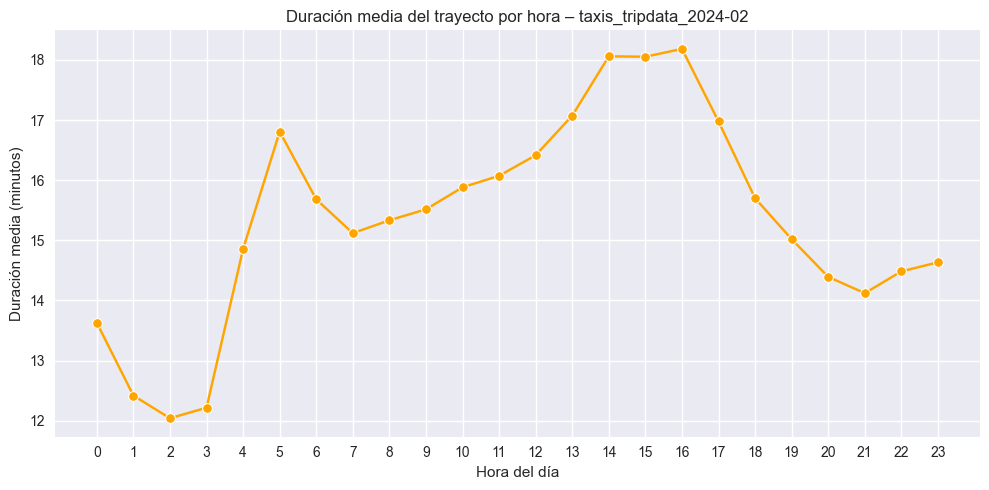

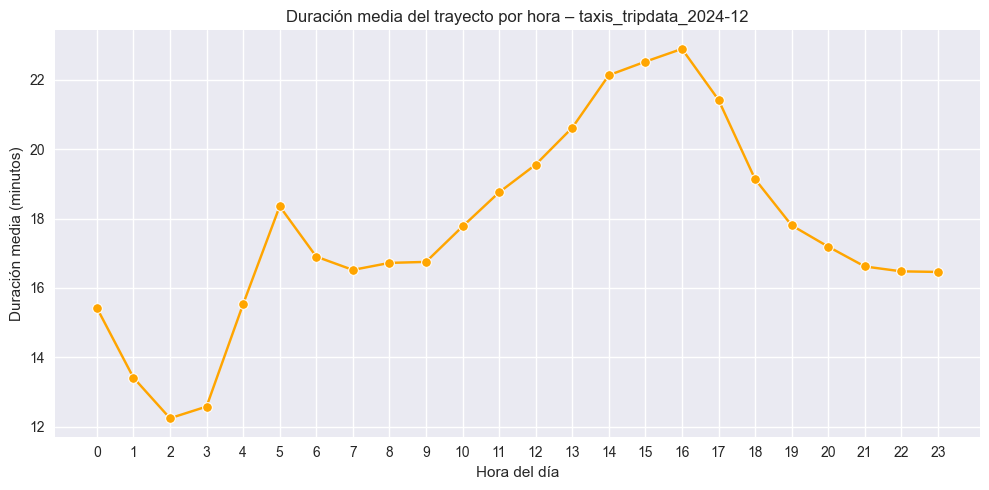

In [236]:
def plot_tiempo_medio_por_hora_dict(datasets_dict):
    """
    Grafica la duración media (en minutos) del trayecto a lo largo del día para cada dataset del diccionario.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
    """
    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Verificar columnas necesarias
        if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
            df['hora'] = pd.to_datetime(df['pickup_datetime'], errors='coerce').dt.hour
            df['duracion_min'] = (
                pd.to_datetime(df['dropoff_datetime'], errors='coerce') -
                pd.to_datetime(df['pickup_datetime'], errors='coerce')
            ).dt.total_seconds() / 60
        else:
            print(f"❌ {nombre}: columnas de fecha no encontradas. Se omite.")
            continue

        df = df[df['duracion_min'] > 0]
        if df.empty:
            print(f"⚠️ {nombre}: sin datos válidos para calcular duración.")
            continue

        media_por_hora = df.groupby('hora')['duracion_min'].mean()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=media_por_hora.index, y=media_por_hora.values, marker="o", color="orange")
        plt.title(f"Duración media del trayecto por hora – {nombre}")
        plt.xlabel("Hora del día")
        plt.ylabel("Duración media (minutos)")
        plt.xticks(range(0, 24))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Generar gráficos de duración media por hora para los datasets limpios
plot_tiempo_medio_por_hora_dict(cleaned_datasets)

### Muestra la evolución de la distancia media de trayecto a lo largo del día.

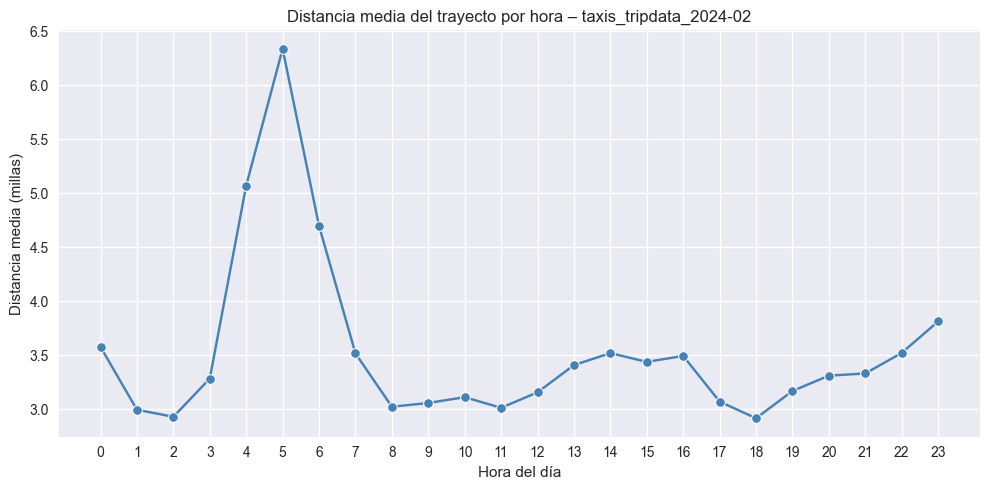

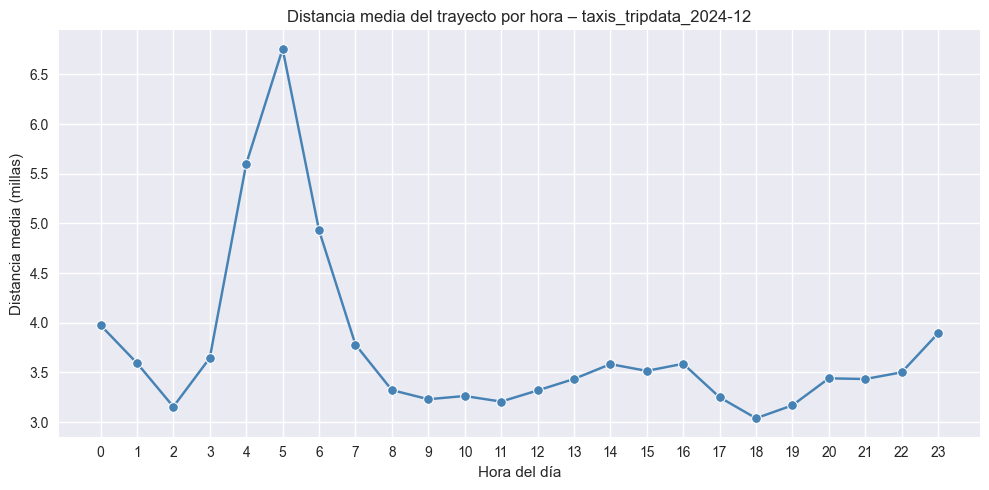

In [237]:
def plot_distancia_media_por_hora_dict(datasets_dict):
    """
    Grafica la distancia media (millas) del trayecto a lo largo del día para cada dataset del diccionario.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
    """
    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Verificar columnas necesarias
        if 'pickup_datetime' in df.columns and 'trip_distance' in df.columns:
            df['hora'] = pd.to_datetime(df['pickup_datetime'], errors='coerce').dt.hour
        else:
            print(f"❌ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        df = df[df['trip_distance'] > 0]
        if df.empty:
            print(f"⚠️ {nombre}: sin datos válidos para calcular distancia.")
            continue

        media_por_hora = df.groupby('hora')['trip_distance'].mean()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=media_por_hora.index, y=media_por_hora.values, marker="o", color="steelblue")
        plt.title(f"Distancia media del trayecto por hora – {nombre}")
        plt.xlabel("Hora del día")
        plt.ylabel("Distancia media (millas)")
        plt.xticks(range(0, 24))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Generar gráficos de distancia media por hora para los datasets limpios
plot_distancia_media_por_hora_dict(cleaned_datasets)

## 2.4	Elige dos zonas cualesquiera de la ciudad y calcula la probabilidad de desplazarse de una zona a otra en menos de X minutos. (El valor X, así como las zonas deben ser fácilmente modificables).

In [240]:
from datetime import time


def calcular_probabilidad_desplazamiento_rapido_dict(
    datasets_dict, 
    origen, 
    destino, 
    umbral_min=10,
    filtro_horas=None,
    rango_duracion_valida=(1, 180),
    incluir_analisis_temporal=False,
    column_groups=None
):
    """
    Calcula la probabilidad de que un trayecto entre dos zonas específicas dure menos de X minutos
    para cada dataset del diccionario, con normalización de nombres de columnas.

    Parámetros:
        - datasets_dict: diccionario {nombre_dataset: DataFrame}
        - origen: ID de la zona de origen (int)
        - destino: ID de la zona de destino (int)
        - umbral_min: duración máxima para considerar un trayecto como rápido (por defecto 10 minutos)
        - filtro_horas: tupla (hora_inicio, hora_fin) para filtrar por franja horaria (opcional)
        - rango_duracion_valida: tupla (min, max) para considerar trayectos válidos (por defecto 1-180 mins)
        - incluir_analisis_temporal: si True, añade análisis por hora y día de la semana (opcional)
        - column_groups: diccionario con mapeo de nombres de columnas alternativos

    Retorna:
        - DataFrame con resultados consolidados
        - Si incluir_analisis_temporal=True, retorna tupla (resultados, analisis_temporal)
    """
    # Configuración por defecto de grupos de columnas
    if column_groups is None:
        column_groups = {
            'PULocationID': ['PUlocationID', 'PULocationID'],
            'DOLocationID': ['DOlocationID', 'DOLocationID'],
            'pickup_datetime': [
                'tpep_pickup_datetime', 'lpep_pickup_datetime',
                'pickup_datetime', 'Trip_Pickup_DateTime',
                'request_datetime'
            ],
            'dropoff_datetime': [
                'tpep_dropoff_datetime', 'lpep_dropoff_datetime',
                'dropOff_datetime', 'dropoff_datetime', 'on_scene_datetime',
                'Trip_Dropoff_DateTime'
            ]
        }

    resultados = []
    analisis_temporal = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()
        
        # Normalización de nombres de columnas
        def encontrar_columna(column_group):
            for nombre_estandar in column_group:
                if nombre_estandar in df.columns:
                    return nombre_estandar
            return None
        
        columnas_encontradas = {}
        for col_estandar, alternativas in column_groups.items():
            col_encontrada = encontrar_columna([col_estandar] + alternativas)
            if col_encontrada:
                columnas_encontradas[col_estandar] = col_encontrada
            else:
                print(f"❌ {nombre}: no se encontró columna para {col_estandar} (alternativas: {alternativas})")
                break
        
        if len(columnas_encontradas) != len(column_groups):
            continue
            
        # Renombrar columnas a nombres estandarizados
        df = df.rename(columns={v: k for k, v in columnas_encontradas.items()})
        
        try:
            # Convertir fechas y calcular duración
            df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
            df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
            df['duracion_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
            
            # Filtrar por franja horaria si se especifica
            if filtro_horas:
                hora_inicio, hora_fin = filtro_horas
                mask_hora = (df['pickup_datetime'].dt.time >= time(hora_inicio)) & \
                            (df['pickup_datetime'].dt.time <= time(hora_fin))
                df = df[mask_hora].copy()
            
            # Filtrar trayectos válidos
            min_duracion, max_duracion = rango_duracion_valida
            trayectos = df[
                (df['PULocationID'] == origen) &
                (df['DOLocationID'] == destino) &
                (df['duracion_min'].notna()) &
                (df['duracion_min'] >= min_duracion) &
                (df['duracion_min'] <= max_duracion)
            ].copy()
            
            total = len(trayectos)
            if total == 0:
                print(f"⚠️ {nombre}: sin trayectos válidos entre {origen} → {destino}.")
                continue
                
            rapidos = trayectos[trayectos['duracion_min'] < umbral_min]
            probabilidad = len(rapidos) / total
            
            # Resultado principal
            resultados.append({
                'Dataset': nombre,
                'Trayectos': total,
                'Rápidos (< X min)': len(rapidos),
                'Probabilidad (%)': round(probabilidad * 100, 2),
                'Duración media (min)': round(trayectos['duracion_min'].mean(), 1),
                'Duración mediana (min)': round(trayectos['duracion_min'].median(), 1),
                'Desviación estándar': round(trayectos['duracion_min'].std(), 1)
            })
            
            # Análisis temporal adicional
            if incluir_analisis_temporal and not trayectos.empty:
                trayectos['hora'] = trayectos['pickup_datetime'].dt.hour
                trayectos['dia_semana'] = trayectos['pickup_datetime'].dt.day_name()
                
                prob_por_hora = trayectos.groupby('hora')['duracion_min'] \
                    .apply(lambda x: (x < umbral_min).mean()) \
                    .reset_index()
                prob_por_hora.columns = ['Hora', 'Probabilidad']
                
                prob_por_dia = trayectos.groupby('dia_semana')['duracion_min'] \
                    .apply(lambda x: (x < umbral_min).mean()) \
                    .reset_index()
                prob_por_dia.columns = ['Día', 'Probabilidad']
                
                analisis_temporal[nombre] = {
                    'por_hora': prob_por_hora,
                    'por_dia': prob_por_dia,
                    'datos_trayectos': trayectos[['pickup_datetime', 'duracion_min']]
                }
            
            print(f"\n📊 {nombre}:")
            print(f"- Total trayectos {origen} → {destino}: {total}")
            print(f"- Trayectos < {umbral_min} min: {len(rapidos)} ({probabilidad:.2%})")
            print(f"- Duración media: {trayectos['duracion_min'].mean():.1f} min")
            print(f"- Desviación estándar: {trayectos['duracion_min'].std():.1f} min")
            
        except Exception as e:
            print(f"❌ {nombre}: error en procesamiento - {str(e)}")
            continue
    
    # Resultados finales
    df_resultados = pd.DataFrame(resultados)
    
    if incluir_analisis_temporal:
        return df_resultados, analisis_temporal
    return df_resultados


# Ejemplo: ¿Qué probabilidad hay de ir de Midtown Center (161) a West Chelsea (246) en menos de 15 minutos?
# Uso avanzado con análisis temporal
zona_origen = 161  # Midtown Center
zona_destino = 246 # West Chelsea
nombre_origen = zona_nombres.get(zona_origen, "Desconocido")
nombre_destino = zona_nombres.get(zona_destino, "Desconocido")

print(f"\nProbabilidad de llegar de {zona_origen} - {nombre_origen} a {zona_destino} - {nombre_destino} en menos de 15 min:")
resultados, analisis = calcular_probabilidad_desplazamiento_rapido_dict(
    datasets_dict=cleaned_datasets,
    origen=161,
    destino=246,
    umbral_min=15,
    filtro_horas=(7, 20),  # Solo trayectos entre 7am y 8pm
    incluir_analisis_temporal=True
)


Probabilidad de llegar de 161 - Midtown Center a 246 - West Chelsea/Hudson Yards en menos de 15 min:

📊 taxis_tripdata_2024-02:
- Total trayectos 161 → 246: 2218
- Trayectos < 15 min: 904 (40.76%)
- Duración media: 16.8 min
- Desviación estándar: 5.2 min

📊 taxis_tripdata_2024-12:
- Total trayectos 161 → 246: 2333
- Trayectos < 15 min: 516 (22.12%)
- Duración media: 21.4 min
- Desviación estándar: 7.8 min


## 2.5	Repite los apartados 1.1, 1.2, 1.3, 1.4, 2.1, 2.2, 2.3 y 2.4 con un dataset del mismo mes, pero del año 2009. Comenta todas las diferencias que vayas encontrando.


Febrero de 2009
Se realizará en las funciones anteriores, añadiendo el nuevo DataSet yellow_tripdata_2009-02

# Tercera Parte: Análisis Predictivo

## 3.1	¿Cuáles son las zonas donde es más probable coger un taxi en función de la hora del día?


In [ ]:
def analizar_probabilidad_pickup_por_zona(datasets_dict):
    """
    Calcula y visualiza las zonas con más probabilidad de coger un taxi según la hora del día.
    Incluye:
    - Heatmap general de todas las zonas.
    - Gráfico de líneas para el top 10 zonas.
    - Heatmap restringido al top 20 zonas.
    """
    # Concatenar todos los datasets que tengan pickup_datetime y PULocationID
    data = []
    for nombre, df in datasets_dict.items():
        if 'pickup_datetime' in df.columns and 'PULocationID' in df.columns:
            temp = df[['pickup_datetime', 'PULocationID']].copy()
            temp["dataset"] = nombre
            data.append(temp)
    if not data:
        print("❌ Ningún dataset tiene las columnas requeridas.")
        return
    
    df_all = pd.concat(data)
    df_all['pickup_datetime'] = pd.to_datetime(df_all['pickup_datetime'], errors='coerce')
    df_all = df_all.dropna(subset=['pickup_datetime', 'PULocationID'])
    df_all['hour'] = df_all['pickup_datetime'].dt.hour

    # Calcular número de pickups por zona y hora
    pickup_counts = df_all.groupby(['hour', 'PULocationID']).size().reset_index(name='count')

    # Normalizar por hora (para obtener probabilidad relativa)
    total_por_hora = pickup_counts.groupby('hour')['count'].transform('sum')
    pickup_counts['probabilidad'] = pickup_counts['count'] / total_por_hora

    # Pivot para heatmap completo
    pivot = pickup_counts.pivot(index='PULocationID', columns='hour', values='probabilidad').fillna(0)

    # Visualización 1: Gráfico de líneas para top 10 zonas
    top_zonas = df_all["PULocationID"].value_counts().head(10).index
    df_top = df_all[df_all["PULocationID"].isin(top_zonas)]
    top_line_df = df_top.groupby(["hour", "PULocationID"]).size().unstack().fillna(0)

    plt.figure(figsize=(12, 6))
    top_line_df.plot(marker="o")
    plt.title("📈 Evolución horaria de los 10 PULocationID más activos")
    plt.xlabel("Hora del día")
    plt.ylabel("Número de pickups")
    plt.grid(True)
    plt.legend(title="Zona", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Visualización 2: Heatmap de top 20 zonas
    top_20 = df_all["PULocationID"].value_counts().head(20).index
    filtered = df_all[df_all["PULocationID"].isin(top_20)].copy()
    filtered["hour"] = pd.to_datetime(filtered["pickup_datetime"]).dt.hour
    heat_df = filtered.groupby(["PULocationID", "hour"]).size().unstack(fill_value=0)
    heat_df = heat_df.div(heat_df.sum(axis=1), axis=0)  # Normalizar por zona

    plt.figure(figsize=(12, 6))
    sns.heatmap(heat_df, cmap="YlOrBr", annot=True, fmt=".2f")
    plt.title("🔥 Probabilidad normalizada por zona (Top 20)")
    plt.xlabel("Hora del día")
    plt.ylabel("Zona")
    plt.tight_layout()
    plt.show()

In [ ]:
# Ejecutar la función para analizar la probabilidad de recoger un taxi por hora y zona
analizar_probabilidad_pickup_por_zona(cleaned_added_datasets)


## 3.2	¿Cuál es la mejor hora del día para ir al aeropuerto?

Objetivo: Saber a qué hora los trayectos al aeropuerto son más rápidos.

In [ ]:
def analizar_horas_para_ir_aeropuerto(dict_datasets, zona_nombres):

    # 1. Detectar zonas de aeropuerto automáticamente
    aeropuerto_ids = [
        zona_id for zona_id, nombre in zona_nombres.items()
        if isinstance(nombre, str) and (
            'airport' in nombre.lower() or 'jfk' in nombre.lower() or 'laguardia' in nombre.lower()
        )
    ]

    if not aeropuerto_ids:
        print("❌ No se detectaron zonas de aeropuerto en zona_nombres.")
        return

    print("🛫 IDs de aeropuerto detectados:", aeropuerto_ids)

    data = []

    # 2. Recolectar trayectos a aeropuerto
    for nombre, df in dict_datasets.items():
        if all(col in df.columns for col in ['pickup_datetime', 'DOLocationID', 'trip_duration_min']):
            temp = df[['pickup_datetime', 'DOLocationID', 'trip_duration_min']].copy()
            temp = temp[temp['DOLocationID'].isin(aeropuerto_ids)]
            temp['hour'] = pd.to_datetime(temp['pickup_datetime'], errors='coerce').dt.hour
            temp.dropna(subset=['hour', 'trip_duration_min'], inplace=True)
            data.append(temp)

    if not data:
        print("❌ No hay trayectos con destino a aeropuerto.")
        return

    df_aeropuerto = pd.concat(data)

    # 3. Agrupaciones
    duracion_media = df_aeropuerto.groupby('hour')['trip_duration_min'].mean().reset_index(name='duración_media_min')
    frecuencia = df_aeropuerto.groupby('hour').size().reset_index(name='n_trayectos')

    resumen = pd.merge(duracion_media, frecuencia, on='hour')

    # 4. Selección de mejor hora
    top_frecuencia = resumen['n_trayectos'].quantile(0.7)
    candidatos = resumen[resumen['n_trayectos'] >= top_frecuencia]
    mejor_hora = candidatos.sort_values('duración_media_min').iloc[0]

    # 5. Visualización
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle("🛫 Análisis de la mejor hora para ir al aeropuerto", fontsize=16)

    sns.lineplot(x='hour', y='duración_media_min', data=resumen, marker='o', ax=axs[0], color='orange')
    axs[0].axvline(mejor_hora['hour'], color='green', linestyle='--', label=f'Mejor hora: {int(mejor_hora["hour"])}h')
    axs[0].set_title("Duración media del trayecto por hora")
    axs[0].set_ylabel("Duración media (min)")
    axs[0].set_xlabel("Hora")
    axs[0].legend()
    axs[0].grid(True)

    sns.barplot(x='hour', y='n_trayectos', data=resumen, ax=axs[1], palette='Blues_d')
    axs[1].axvline(mejor_hora['hour'], color='green', linestyle='--')
    axs[1].set_title("Frecuencia de trayectos al aeropuerto por hora")
    axs[1].set_ylabel("Nº de trayectos")
    axs[1].set_xlabel("Hora")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # 6. Imprimir resumen
    print("\n📝 Recomendación:")
    print(f"La mejor hora para ir al aeropuerto es las **{int(mejor_hora['hour'])}:00 h**.")
    print(f"- Duración media estimada: {mejor_hora['duración_media_min']:.1f} minutos.")
    print(f"- Número de trayectos registrados en esa hora: {mejor_hora['n_trayectos']}.")

    return resumen



In [ ]:
resumen_aeropuerto = analizar_horas_para_ir_aeropuerto(cleaned_added_datasets, zona_nombres)

## 3.3	Diseña un modelo que, dada una hora, una zona origen, y una zona destino, predice la duración del trayecto y su coste. Muestra la relevancia de los atributos del dataset.

## Predicción de duración y coste del trayecto dada la hora, la zona de origen y la zona de destino.
- Dado:
    - hora (extraída de pickup_datetime)
    - zona origen (PULocationID)
    - zona destino (DOLocationID)

- Predecir:
    - trip_duration_min
    - total_amount

In [ ]:
def preparar_dataset_modelo_total_amount_log(datasets_dict):
    """
    Prepara los datos a partir de un diccionario de datasets para predecir duración y total_amount.
    - Combina todos los DataFrames en uno.
    - Filtra y limpia outliers.
    - Crea variables: hora, día_semana, log_duración.
    - Devuelve X, y_duracion_log, y_total, df final.
    """
    # Unir todos los datasets válidos en uno
    dfs = []
    for nombre, df in datasets_dict.items():
        if {"pickup_datetime", "PULocationID", "DOLocationID", "trip_distance", "total_amount"}.issubset(df.columns):
            dfs.append(df[["pickup_datetime", "PULocationID", "DOLocationID", "trip_distance", "total_amount", "trip_duration_min"]].copy())
    if not dfs:
        raise ValueError("No hay datasets válidos con las columnas requeridas.")
    
    df = pd.concat(dfs, ignore_index=True)
    
    # Limpiar registros inválidos
    df = df.dropna(subset=["pickup_datetime", "PULocationID", "DOLocationID", "trip_distance", "total_amount", "trip_duration_min"])
    df = df[
        (df["trip_distance"] > 0) & 
        (df["total_amount"] > 0) & 
        (df["trip_duration_min"] > 0)
    ].copy()
    
    # Transformaciones
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
    df["hour"] = df["pickup_datetime"].dt.hour
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    df["log_duration"] = np.log1p(df["trip_duration_min"])
    
    # Preparar features y targets
    X = df[["hour", "day_of_week", "PULocationID", "DOLocationID", "trip_distance"]]
    y_duracion_log = df["log_duration"]
    y_total = df["total_amount"]
    
    return X, y_duracion_log, y_total, df

# Probamos si carga correctamente
X, y_duracion_log, y_total, df_modelo = preparar_dataset_modelo_total_amount_log(cleaned_added_datasets)


Entrenar y evaluar los modelos de RandomForest: duración y coste

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

def entrenar_y_evaluar_modelos(df_modelo):
    """
    Entrena y evalúa dos modelos de RandomForest: duración y coste.
    """
    # Variables predictoras y objetivo
    X = df_modelo[["hour", "PULocationID", "DOLocationID"]]
    y_duracion = df_modelo["trip_duration_min"]
    y_precio = df_modelo["total_amount"]

    # Codificación categórica con OneHot
    preprocesador = ColumnTransformer(
        transformers=[
            ("onehot", OneHotEncoder(handle_unknown="ignore"), ["PULocationID", "DOLocationID"])
        ],
        remainder='passthrough'  # deja pasar la hora
    )

    # Modelo para duración
    modelo_duracion = Pipeline([
        ("preprocesado", preprocesador),
        ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
    ])

    # Modelo para precio
    modelo_precio = Pipeline([
        ("preprocesado", preprocesador),
        ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
    ])

    # División train-test
    X_train, X_test, y_train_d, y_test_d = train_test_split(X, y_duracion, test_size=0.2, random_state=42)
    _, _, y_train_p, y_test_p = train_test_split(X, y_precio, test_size=0.2, random_state=42)

    print("🔁 Entrenando modelo de duración...")
    modelo_duracion.fit(X_train, y_train_d)

    print("🔁 Entrenando modelo de precio total...")
    modelo_precio.fit(X_train, y_train_p)

    # Predicciones
    y_pred_d = modelo_duracion.predict(X_test)
    y_pred_p = modelo_precio.predict(X_test)

    # Evaluación
    print("\n📊 Evaluación modelo de duración:")
    print(f"- MAE: {mean_absolute_error(y_test_d, y_pred_d):.2f} minutos")
    print(f"- RMSE: {np.sqrt(mean_squared_error(y_test_d, y_pred_d)):.2f}")
    print(f"- R²: {r2_score(y_test_d, y_pred_d):.2f}")

    print("\n📊 Evaluación modelo de precio total:")
    print(f"- MAE: {mean_absolute_error(y_test_p, y_pred_p):.2f} $")
    print(f"- RMSE: {np.sqrt(mean_squared_error(y_test_p, y_pred_p)):.2f}")
    print(f"- R²: {r2_score(y_test_p, y_pred_p):.2f}")

    return modelo_duracion, modelo_precio


In [ ]:
# Entrenar y evaluar los modelos (duración y precio)
# 12minutos
modelo_duracion, modelo_precio = entrenar_y_evaluar_modelos(df_modelo)

In [ ]:
def predecir_trayecto(modelo_duracion, modelo_precio, hora, zona_origen, zona_destino):
    """
    Realiza la predicción para un trayecto y muestra la importancia de los atributos.

    Parámetros:
        modelo_duracion: modelo entrenado para duración
        modelo_precio: modelo entrenado para coste
        hora: int (0-23)
        zona_origen: int (PULocationID)
        zona_destino: int (DOLocationID)

    Retorna:
        dict con predicciones y DataFrame con importancia de atributos
    """
    entrada = pd.DataFrame([{
        "hour": hora,
        "PULocationID": zona_origen,
        "DOLocationID": zona_destino
    }])

    # Predicción
    duracion_pred = modelo_duracion.predict(entrada)[0]
    precio_pred = modelo_precio.predict(entrada)[0]

    # Extraer importancias del modelo RandomForest (tras preprocessing)
    rf_duracion = modelo_duracion.named_steps["rf"]
    rf_precio = modelo_precio.named_steps["rf"]
    preproc = modelo_duracion.named_steps["preprocesado"]
    feature_names = preproc.get_feature_names_out()

    importancias_duracion = pd.Series(rf_duracion.feature_importances_, index=feature_names)
    importancias_precio = pd.Series(rf_precio.feature_importances_, index=feature_names)

    top_importancia_duracion = importancias_duracion.sort_values(ascending=False).head(10)
    top_importancia_precio = importancias_precio.sort_values(ascending=False).head(10)

    return {
        "duracion_minutos_estimada": round(duracion_pred, 2),
        "precio_estimado_dolares": round(precio_pred, 2),
        "importancia_duracion": top_importancia_duracion,
        "importancia_precio": top_importancia_precio
    }


In [ ]:
resultado = predecir_trayecto(modelo_duracion, modelo_precio, 14, 132, 230)
print(f"🕒 Duración estimada: {resultado['duracion_minutos_estimada']} min")
print(f"💵 Precio estimado: {resultado['precio_estimado_dolares']} $")
print("\n📊 Atributos más relevantes para duración:")
print(resultado["importancia_duracion"])
print("\n📊 Atributos más relevantes para precio:")
print(resultado["importancia_precio"])


In [ ]:
from sklearn.model_selection import cross_val_score

def evaluar_con_cross_validation(modelo, X, y, nombre="Modelo"):
    """
    Aplica validación cruzada y muestra MAE, RMSE y R² promedio.

    Parámetros:
        modelo: Pipeline sklearn (con preprocesamiento y modelo)
        X: variables predictoras
        y: variable objetivo
        nombre: identificador del modelo

    Retorna:
        dict con métricas promedio
    """
    print(f"\n🔁 Evaluando {nombre} con cross-validation (cv=5)...")

    # MAE (negativo por convención sklearn)
    scores_mae = cross_val_score(modelo, X, y, cv=5, scoring='neg_mean_absolute_error')
    scores_rmse = cross_val_score(modelo, X, y, cv=5, scoring='neg_root_mean_squared_error')
    scores_r2 = cross_val_score(modelo, X, y, cv=5, scoring='r2')

    resultados = {
        "MAE": -scores_mae.mean(),
        "RMSE": -scores_rmse.mean(),
        "R2": scores_r2.mean()
    }

    for metric, value in resultados.items():
        print(f"{metric}: {value:.2f}")

    return resultados


In [ ]:
# Variables predictoras
X = df_modelo[["hour", "PULocationID", "DOLocationID"]]
y_duracion = df_modelo["trip_duration_min"]
y_precio = df_modelo["total_amount"]

evaluar_con_cross_validation(modelo_duracion, X, y_duracion, nombre="Duración")
evaluar_con_cross_validation(modelo_precio, X, y_precio, nombre="Precio")
